In [237]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob

from scipy.signal import find_peaks, argrelextrema,argrelmax,argrelmin
import scipy.stats as stats
from scipy.stats import genextreme as gev
import cartopy
import cartopy.crs as ccrs
import matplotlib.colors as colors
import cmaps
from xhistogram.xarray import histogram

from rpy2.robjects.packages import importr, data
from rpy2.robjects import pandas2ri
import rpy2.robjects as ro
from rpy2.robjects import globalenv
pandas2ri.activate()

extRemes = importr("extRemes")

%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [238]:
%config InlineBackend.figure_format = 'retina'
plt.style.use("cma.mplstyle")

In [239]:
from scipy.stats import genextreme as gev
def empirical_return_level(data):
    """
    Compute empirical return level using the algorithm introduced in Tutorial 2
    """
    df = pd.DataFrame(index=np.arange(data.size))
    # sort the data
    df["sorted"] = np.sort(data)[::-1]
    # rank via scipy instead to deal with duplicate values
    df["ranks_sp"] = np.sort(stats.rankdata(-data))
    # find exceedence probability
    n = data.size
    df["exceedance"] = df["ranks_sp"] / (n + 1)
    # find return period
    df["period"] = 1 / df["exceedance"]

    df = df[::-1]

    out = xr.DataArray(
        dims=["period"],
        coords={"period": df["period"]},
        data=df["sorted"],
        name="level",
    )
    return out

In [240]:
yearb=1980
yeare=2008

files=[f'../AFI/AFI_ERA5_{iyear}_fullUSA.nc' for iyear in range(yearb,yeare+1)]

ds=xr.open_mfdataset(files)

return_periods=[2, 5, 10, 25, 50, 100]
return_afi=np.zeros((len(return_periods),len(ds.lat),len(ds.lon)))*np.nan
Rmethod=np.zeros((len(ds.lat),len(ds.lon)))*np.nan
Tlon=ds.lon.data
Tlat=ds.lat.data

units='degree-days (°F)'

In [241]:
ptlon=[260,270,264.25,241,205,204]
ptlat=[48,40,37,46.25,68.75,60]

In [242]:
c=[1.1,1.6,2,3,4,5,6,7,8,9,10,15, 20,25, 50,75, 100, 200,500,750,1000]
ksN=9999
year=np.arange(1980,2009)
# create vector of years
years = np.arange(1.1, 100, 0.1)

Text(0.5, 0.98, 'AFI mean (1980-2009)')

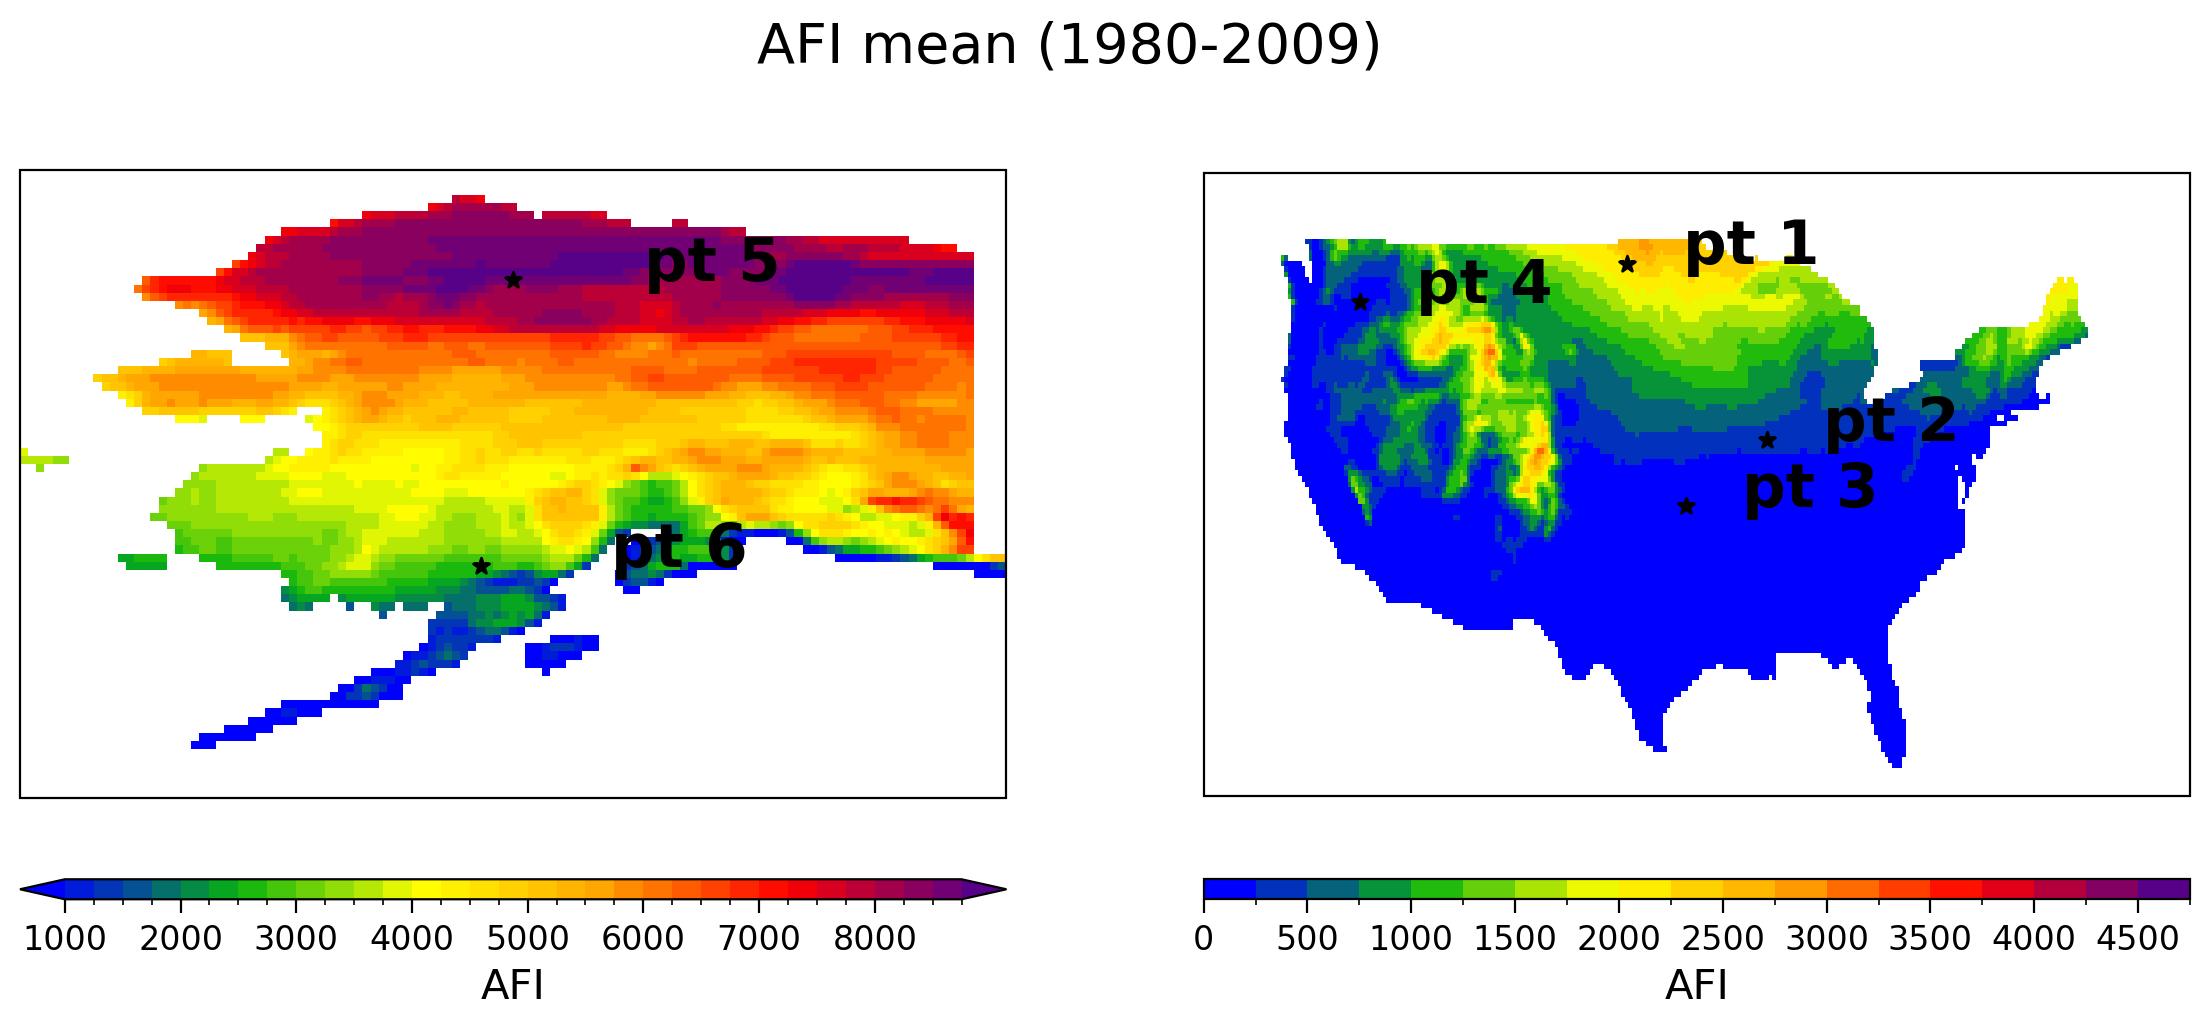

In [243]:
cmap=cmaps.BlGrYeOrReVi200
proj=ccrs.PlateCarree()
fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(14,5),subplot_kw={'projection':proj})
plt.subplots_adjust(bottom=0.15, right=0.9)

cc=ds['AFI'].where(ds['AFI']>0.).mean('time').sel(lon=slice(190,220),lat=slice(72,53)).plot(ax=ax[0],cmap=cmap,levels=np.arange(1000,9000,250),add_colorbar=False)
for ip in range(4,6):
  ax[0].scatter(ptlon[ip],ptlat[ip],marker='*',color='k')
  ax[0].text(ptlon[ip]-360+4,ptlat[ip],f'pt {ip+1}',color='k',size=22,weight='bold')
p0 = ax[0].get_position().get_points().flatten()
ax_cbar = fig.add_axes([p0[0], 0.1, p0[2]-p0[0], 0.02])
cbar=fig.colorbar(cc,cax=ax_cbar,\
        shrink=0.5,\
        orientation='horizontal',label='AFI')
cbar.ax.tick_params(labelsize=12)

cc=ds['AFI'].where(ds['AFI']>0.).mean('time').sel(lon=slice(230,300),lat=slice(52,22)).plot(ax=ax[1],cmap=cmap,levels=np.arange(0,5000,250),add_colorbar=False)
for ip in range(0,4):
  ax[1].scatter(ptlon[ip],ptlat[ip],marker='*',color='k')
  ax[1].text(ptlon[ip]-360+4,ptlat[ip],f'pt {ip+1}',color='k',size=22,weight='bold')
p0 = ax[1].get_position().get_points().flatten()
ax_cbar = fig.add_axes([p0[0], 0.1, p0[2]-p0[0], 0.02])
cbar=fig.colorbar(cc,cax=ax_cbar,\
        shrink=0.5,\
        orientation='horizontal',label='AFI')
cbar.ax.tick_params(labelsize=12)

asp = np.diff(ax[0].get_xlim())[0] / np.diff(ax[0].get_ylim())[0]
ax[1].set_aspect(asp)
plt.suptitle('AFI mean (1980-2009)', fontsize=20)

# Pt 1

In [244]:
ij=0
ilon=ptlon[ij]
ilat=ptlat[ij]
afi=ds['AFI'].sel(lon=ilon,lat=ilat).load()

In [245]:
# Extract AFI values
afi_values = afi.values
# Remove zeros if any (as in Bilotta et al.)
nonzero_afis = afi_values[afi_values > 0]

df = afi.where(afi>0).to_dataframe()
df=df.drop(columns=['lat','lon'])
df['year'] = df.index

# Convert pandas DataFrame to R data.frame
r_df = ro.conversion.py2rpy(df)

# You can now work with 'r_df' in R
print(ro.r['summary'](r_df))
globalenv['r_df'] = r_df

['Min.   :1327  ' '1st Qu.:1778  ' 'Median :2328  ' 'Mean   :2276  '
 '3rd Qu.:2633  ' 'Max.   :3439  ' 'Min.   :1980  ' '1st Qu.:1987  '
 'Median :1994  ' 'Mean   :1994  ' '3rd Qu.:2001  ' 'Max.   :2008  ']


Define fit for GEV, Gumbel, Frechet, Weibull

In [246]:
%R fitGEV <- fevd(AFI, data = r_df,type='GEV',method='MLE')
%R fitGumb <- fevd(AFI, data = r_df,type='Gumbel',method='MLE') # Gumbel shape=0
%R -o fitGEV,fitGumb


In [247]:
locGEV,scaleGEV,shapeGEV=fitGEV['results']['par']
locGumb,scaleGumb=fitGumb['results']['par']
globalenv['locGEV'] =locGEV 
globalenv['scaleGEV']=scaleGEV
globalenv['shapeGEV']=shapeGEV
globalenv['locGumb'] =locGumb
globalenv['scaleGumb']=scaleGumb
print('R GEV',fitGEV['results']['par'])
print('R Gumbel',fitGumb['results']['par'])

R GEV [ 2.04502392e+03  5.50267287e+02 -2.11433340e-01]
R Gumbel [1998.78433768  517.01014504]


In [248]:
fitGumb

o{'call': 
fevd(x = AFI, data = r_df, type = "Gumbel", method = "MLE")

[1] "Estimation Method used: MLE"


 Negative Log-Likelihood Value:  225.8794 


 Estimated parameters:
 location     scale 
1998.7843  517.0101 

 Standard Error Estimates:
 location     scale 
101.46358  76.72275 

 Estimated parameter covariance matrix.
         location   scale
location 10294.86 2567.10
scale     2567.10 5886.38

 AIC = 455.7588 

 BIC = 458.4934 
, 'data.name': ['AFI' 'r_df'], 'weights': [1.], 'in.data': [1] TRUE
, 'x.fun': AFI ~ 1
<environment: 0x7fdd642ef580>
, 'missing.values':  [1] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
[13] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
[25] FALSE FALSE FALSE FALSE FALSE
, 'x': [1745.27148438 2988.45751953 1566.74572754 2445.00341797 2559.55419922
 2537.46069336 1542.76879883 1910.28613281 2633.16162109 1778.18737793
 2036.65454102 1609.90393066 2665.57397461 2877.93408203 2327.66894531
 3383.41406

In [249]:
#%R fpGEV<-plot(fitGEV, type = "rl", main = "Return Level Plot - GEV")
#%R fpGumb<-plot(fitGumb, type = "rl", add = TRUE, col = "red") # Add Gumbel plot with a different color


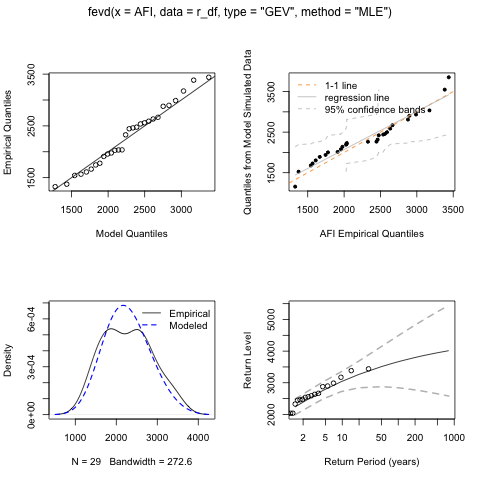

In [250]:
%R plot(fitGEV)

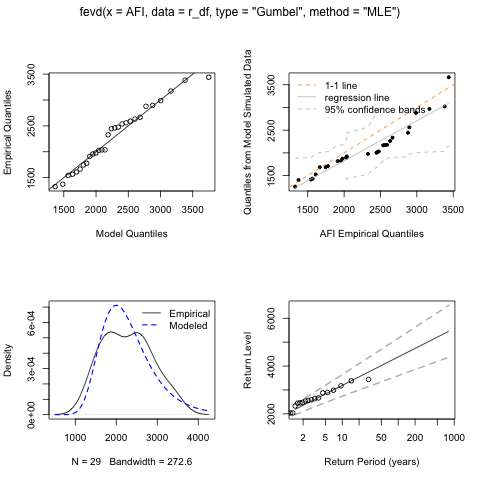

In [251]:
%R plot(fitGumb)

In [252]:
#%R fpGEV<-plot(fitGEV,type='rl')
#%R -o fpGEV 

Extract return_periods

In [253]:
%R return_periods <- c( 1.1,1.6,2,3,4,5,6,7,8,9,10,15, 20,25, 50,75, 100, 200,500,750,1000)
%R rlGEV<-return.level(fitGEV, return.period = return_periods, make.plot=TRUE)
%R rlGumb<-return.level(fitGumb, return.period = return_periods, make.plot=TRUE)
#%R rlWei<-return.level(fitWei, return.period = return_periods, make.plot=TRUE)
%R -o rlGEV,rlGumb

In [254]:
from scipy.optimize import minimize,least_squares
def custom_optimizer(func, x0, args=(), disp=0):
    res = minimize(func, x0, args, method="slsqp", options={"disp": disp})
    if res.success:
        return res.x
    raise RuntimeError('optimization routine failed')

def custom_optimizer_G(func, x0, args=(), disp=0):
    res = minimize(func, x0, args, method="trust-constr", options={"disp": disp})
    if res.success:
        return res.x
    raise RuntimeError('optimization routine failed') 
from scipy.optimize import fmin
def optimizer1(func, x0, args=(), disp=False):
    return fmin(func, x0, args=args, disp=disp, xtol=1e-13, ftol=1e-12)


<>:44: SyntaxWarning: invalid escape sequence '\d'
<>:44: SyntaxWarning: invalid escape sequence '\d'
<>:44: SyntaxWarning: invalid escape sequence '\d'
<>:44: SyntaxWarning: invalid escape sequence '\d'
/var/folders/2z/v4x6xdj96rg1k3xrmwt26xtc0000gp/T/ipykernel_36969/2949268573.py:44: SyntaxWarning: invalid escape sequence '\d'
  ax.set_title(f'{ilon}$\degree$E;{ilat}$\degree$N')
/var/folders/2z/v4x6xdj96rg1k3xrmwt26xtc0000gp/T/ipykernel_36969/2949268573.py:44: SyntaxWarning: invalid escape sequence '\d'
  ax.set_title(f'{ilon}$\degree$E;{ilat}$\degree$N')
/Users/ghervieux/miniconda3/envs/gaelle/lib/python3.12/site-packages/scipy/stats/_continuous_distns.py:10453: RuntimeWarning: invalid value encountered in power
  g1 = mu3 / np.power(mu2, 1.5)
/Users/ghervieux/miniconda3/envs/gaelle/lib/python3.12/site-packages/scipy/stats/_distn_infrastructure.py:2855: RuntimeWarning: invalid value encountered in sqrt
  Shat = sqrt(mu2hat / mu2)
/Users/ghervieux/miniconda3/envs/gaelle/lib/python3.1

Text(0.5, 1.0, '260$\\degree$E;48$\\degree$N')

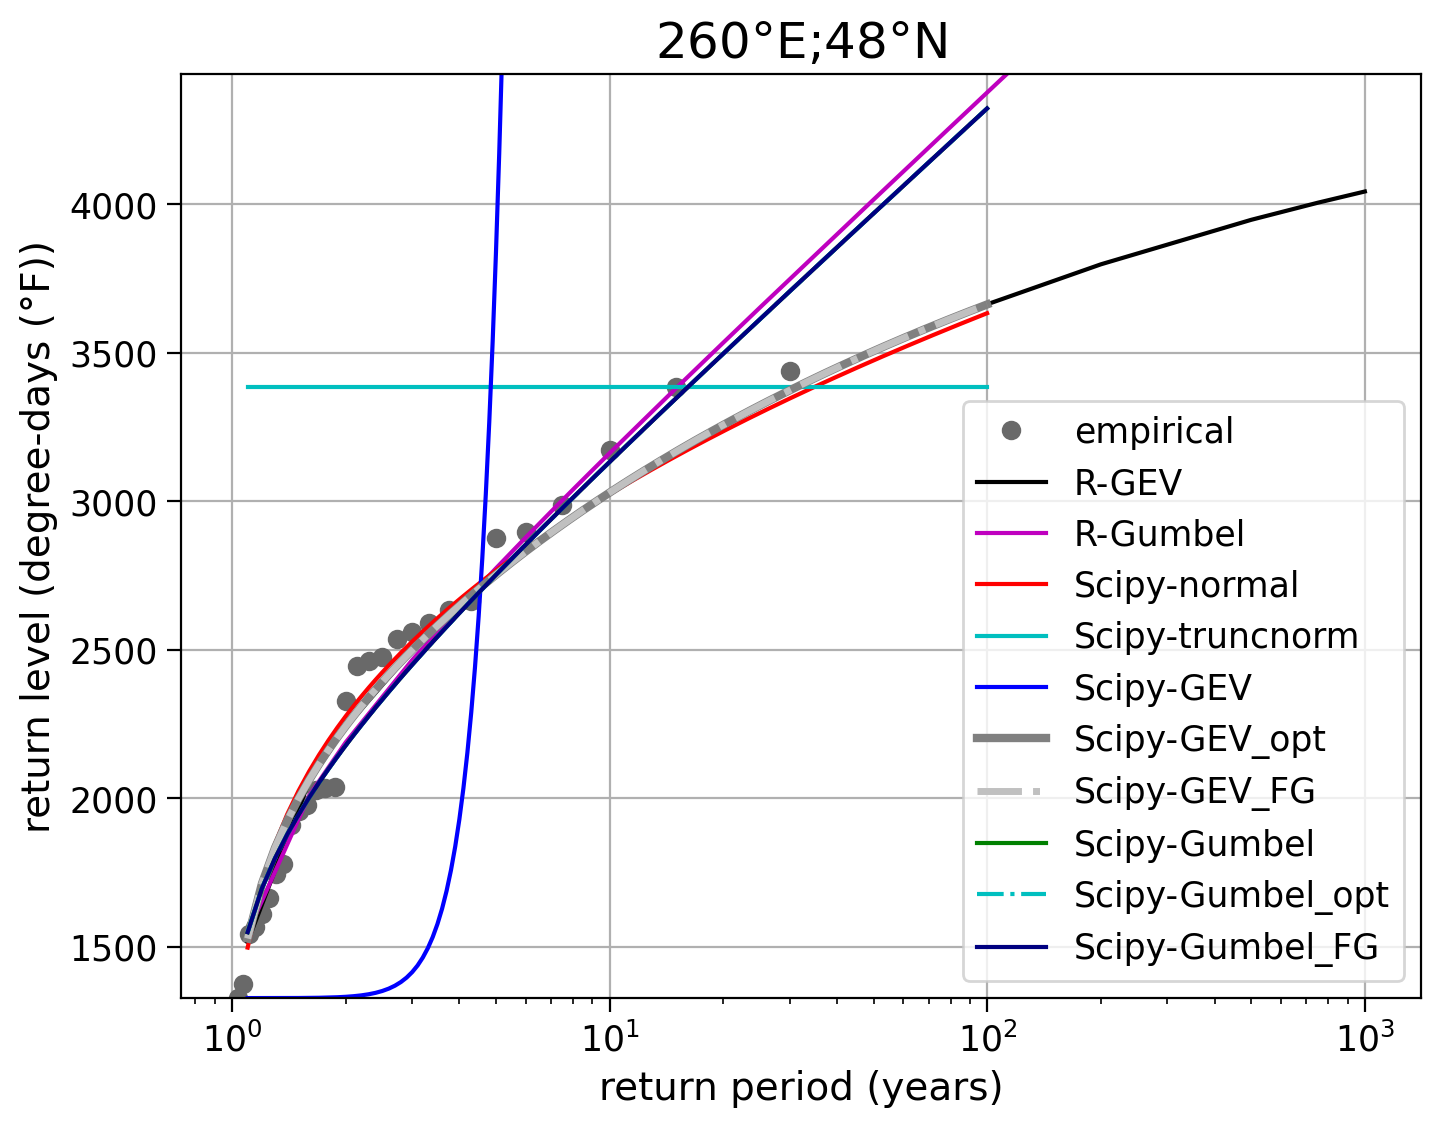

In [255]:

fig, ax = plt.subplots(nrows=1,ncols=1)
_ = empirical_return_level(nonzero_afis).plot(ax=ax, marker="o", color='dimgray',linestyle="None",label="empirical")
ax.plot(c,rlGEV,c='k',label='R-GEV')
ax.plot(c,rlGumb,c='m',label='R-Gumbel')

# create vector of years
years = np.arange(1.1, 100, 0.1)
# calculate and plot the normal return levels

ax.plot(years,stats.norm.ppf(1 - 1 / years, loc=nonzero_afis.mean(), scale=nonzero_afis.std()),c='r',label=f"Scipy-normal")
# calculate and plot the truncated gaussian return levels
ptn = stats.truncnorm.fit(nonzero_afis,  method='mle')
ax.plot(years,stats.truncnorm.ppf(1 - 1 / years,*ptn),c='c',label=f"Scipy-truncnorm")
# calculate and plot the GEV distribution, note the negtive shape parameter
pgev = gev.fit(nonzero_afis)

ax.plot(years, gev.ppf(1 - 1 / years, *pgev),c='b',label=f"Scipy-GEV")
# calculate and plot the GEV distribution, note the negtive shape parameter

pgev = gev.fit(nonzero_afis, method="MLE", optimizer=custom_optimizer)
ax.plot(years, gev.ppf(1 - 1 / years, *pgev),c='grey',lw=3,ls='-',label=f"Scipy-GEV_opt")
pgev = gev.fit(nonzero_afis, loc=nonzero_afis.mean(), scale=nonzero_afis.std(), method="MLE", optimizer=optimizer1)
ax.plot(years, gev.ppf(1 - 1 / years, *pgev),c='silver',lw=2.5,ls='-.',label=f"Scipy-GEV_FG")

# calculate and plot the Gumbel distribution
pgum = gev.fit(nonzero_afis,fc=0,method="MLE")# fc=0 fixes the shape parameter at 0
ax.plot(years, gev.ppf(1 - 1 / years,*pgum),c='g',label=f"Scipy-Gumbel")
pgum = gev.fit(nonzero_afis,fc=0,method="MLE", optimizer=optimizer1)
ax.plot(years, gev.ppf(1 - 1 / years,*pgum),c='c',ls='-.',label=f"Scipy-Gumbel_opt")
pgum = gev.fit(nonzero_afis,fc=0,method="MLE",loc=nonzero_afis.mean(),scale=nonzero_afis.std() , optimizer=optimizer1)
ax.plot(years, gev.ppf(1 - 1 / years,*pgum),c='navy',ls='-',label=f"Scipy-Gumbel_FG")
#ax.set_xlim(0,100)
# set x axis to log scale
ax.set_xscale("log")

ax.set_ylabel(f'return level ({units})',fontsize=14)
ax.set_xlabel('return period (years)',fontsize=14)

ax.grid()
# set y axis lim
ax.set_ylim(nonzero_afis.min(),nonzero_afis.max()+1000.)
# show legend
ax.legend()
ax.set_title(f'{ilon}$\degree$E;{ilat}$\degree$N')

Example to show that
- stats.truncnorm needs to specify first guess to give a sensible result, didn't find an optimizer working.
- stats.genextreme : using optimize option or giving first guess give the same result
- stats.genextreme fc=0 (Gumbel): optimize option, giving first guess or nothing give the same result 

In [256]:
pgum = gev.fit(nonzero_afis,fc=0,method="MLE")
print(pgum)
pgum = gev.fit(nonzero_afis,fc=0,method="MLE", optimizer=optimizer1)
print(pgum)
pgum = gev.fit(nonzero_afis,fc=0,method="MLE",loc=nonzero_afis.mean(),scale=nonzero_afis.std() , optimizer=optimizer1)
print(pgum)

(0, np.float64(1992.0247357423598), np.float64(506.8451752876657))
(0, np.float64(1992.0247468334965), np.float64(506.84515489063557))
(0, np.float64(1992.0247481044828), np.float64(506.8451552992269))


<>:57: SyntaxWarning: invalid escape sequence '\d'
<>:57: SyntaxWarning: invalid escape sequence '\d'
<>:57: SyntaxWarning: invalid escape sequence '\d'
<>:57: SyntaxWarning: invalid escape sequence '\d'
/var/folders/2z/v4x6xdj96rg1k3xrmwt26xtc0000gp/T/ipykernel_36969/2812563141.py:57: SyntaxWarning: invalid escape sequence '\d'
  ax.set_title(f'{ilon}$\degree$E;{ilat}$\degree$N')
/var/folders/2z/v4x6xdj96rg1k3xrmwt26xtc0000gp/T/ipykernel_36969/2812563141.py:57: SyntaxWarning: invalid escape sequence '\d'
  ax.set_title(f'{ilon}$\degree$E;{ilat}$\degree$N')
/Users/ghervieux/miniconda3/envs/gaelle/lib/python3.12/site-packages/scipy/stats/_continuous_distns.py:3398: RuntimeWarning: overflow encountered in exp
  pex2 = np.exp(logpex2)


Text(0.5, 1.0, '260$\\degree$E;48$\\degree$N')

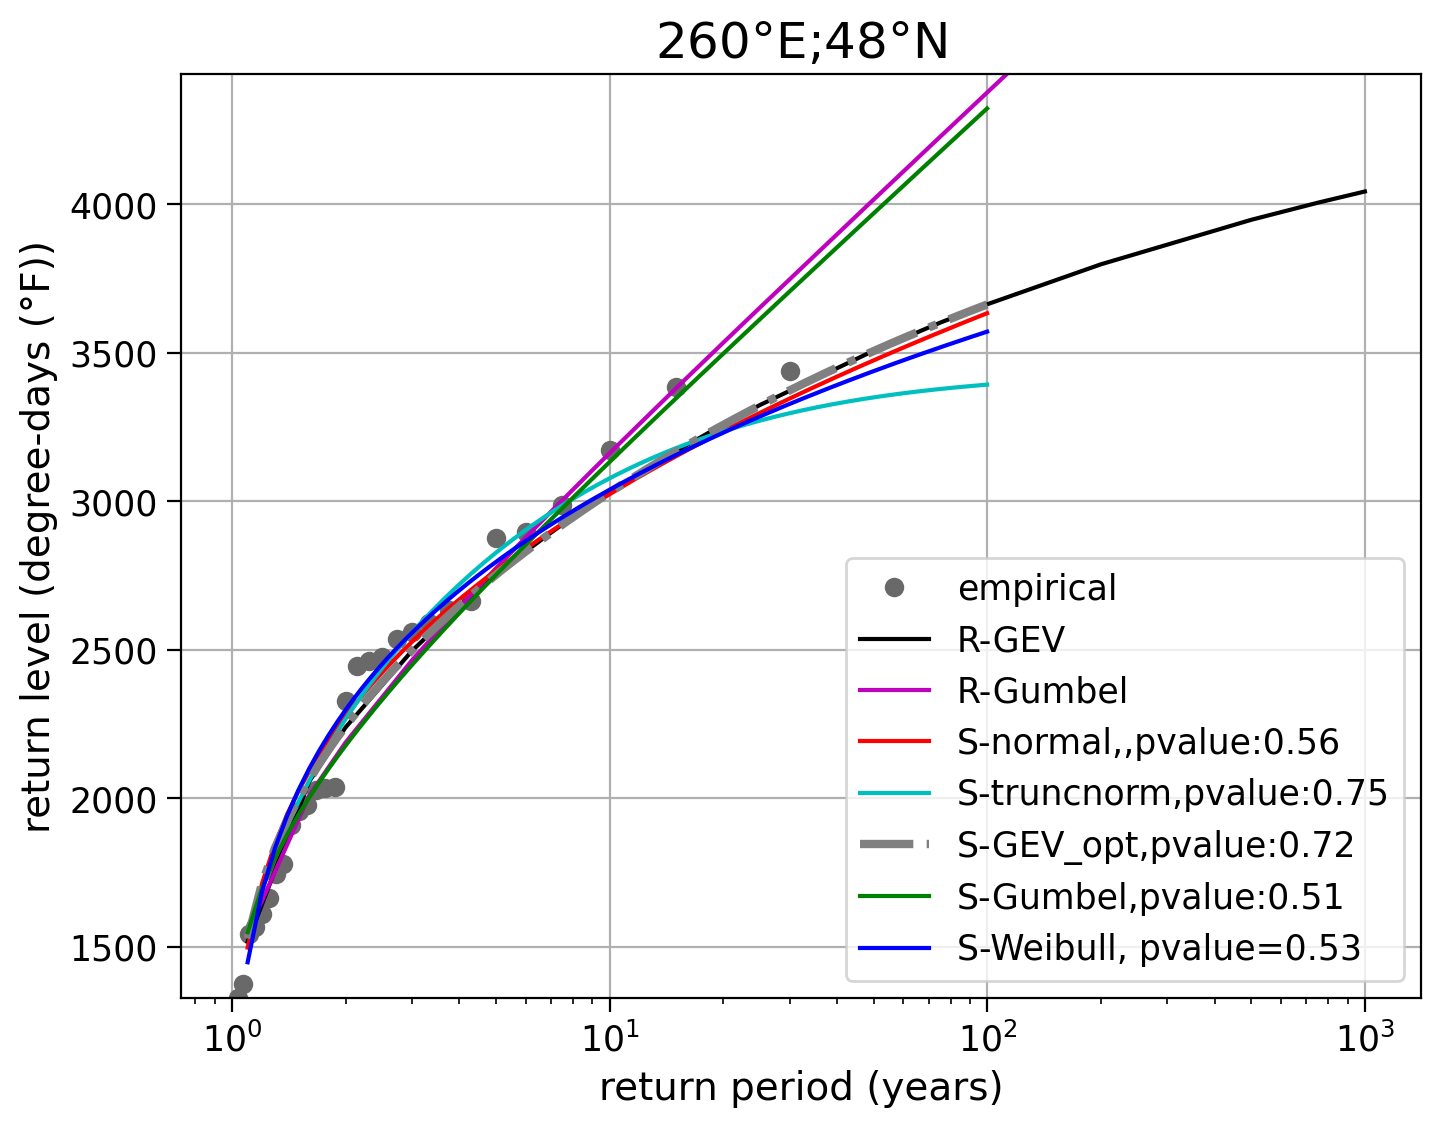

In [257]:

fig, ax = plt.subplots(nrows=1,ncols=1)
# plot empirical 
_ = empirical_return_level(nonzero_afis).plot(ax=ax, marker="o", color='dimgray',linestyle="None",label="empirical")

# plot R-distribution 
ax.plot(c,rlGEV,c='k',label='R-GEV')
ax.plot(c,rlGumb,c='m',label='R-Gumbel')


# calculate and plot the normal return levels
pv_n=np.round(stats.kstest(nonzero_afis,stats.norm.cdf, \
     args=(nonzero_afis.mean(),nonzero_afis.std()),N=ksN)[1],2)
ax.plot(years,stats.norm.ppf(1 - 1 / years, loc=nonzero_afis.mean(), scale=nonzero_afis.std())\
     ,c='r',label=f"S-normal,,pvalue:{pv_n}")

# calculate and plot the truncated gaussian return levels
loc_guess=nonzero_afis.mean()
scale_guess=nonzero_afis.std()
a_guess = (nonzero_afis.min() - loc_guess) / scale_guess
b_guess = (nonzero_afis.max() - loc_guess) / scale_guess

ptn = stats.truncnorm.fit(nonzero_afis,a_guess,b_guess,\
    scale= scale_guess, loc = loc_guess,  method='mle')
pv_tn=np.round(stats.kstest(nonzero_afis,stats.truncnorm.cdf, \
     args=ptn,N=ksN)[1],2)
ax.plot(years,stats.truncnorm.ppf(1 - 1 / years,*ptn),c='c',label=f"S-truncnorm,pvalue:{pv_tn}")

# calculate and plot the GEV distribution, optimized
pgev = gev.fit(nonzero_afis, method="MLE", optimizer=custom_optimizer)
pv_g= np.round(stats.kstest(nonzero_afis, 'genextreme', args=pgev, N=ksN)[1],2)
ax.plot(years, gev.ppf(1 - 1 / years, *pgev),c='grey',lw=3,ls='-.',label=f"S-GEV_opt,pvalue:{pv_g}")

# calculate and plot the Gumbel distribution
pgum = gev.fit(nonzero_afis,fc=0,method="MLE") # fc=0 fixes the shape parameter at 0
pv_gu= np.round(stats.kstest(nonzero_afis, 'genextreme', args=pgum, N=ksN)[1],2)
ax.plot(years, gev.ppf(1 - 1 / years,*pgum),c='g',label=f"S-Gumbel,pvalue:{pv_gu}")

# Weibul distribution
params = stats.weibull_min.fit(nonzero_afis, floc=0,optimizer=optimizer1) # floc=0 fixes the location parameter at 0
c_est, loc_est, scale_est = params
pv_w = stats.kstest(nonzero_afis, stats.weibull_min.name, params,N=ksN)[1]
ax.plot(years, stats.weibull_min(c_est, loc_est, scale_est).ppf(1 - 1 / years),c='b',label=f"S-Weibull, pvalue={pv_w:0.2f}")


#ax.set_xlim(0,100)
# set x axis to log scale
ax.set_xscale("log")

ax.set_ylabel(f'return level ({units})',fontsize=14)
ax.set_xlabel('return period (years)',fontsize=14)

ax.grid()
# set y axis lim
ax.set_ylim(nonzero_afis.min(),nonzero_afis.max()+1000.)
# show legend
ax.legend()
ax.set_title(f'{ilon}$\degree$E;{ilat}$\degree$N')

For point1, R-GEV, S-GEV optimized and S-Gumbel give the same result.

/var/folders/2z/v4x6xdj96rg1k3xrmwt26xtc0000gp/T/ipykernel_36969/348868219.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(),fontsize=14)
/var/folders/2z/v4x6xdj96rg1k3xrmwt26xtc0000gp/T/ipykernel_36969/348868219.py:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(),fontsize=14)


[Text(0, 0.0, '0.0000'),
 Text(0, 0.0002, '0.0002'),
 Text(0, 0.0004, '0.0004'),
 Text(0, 0.0006000000000000001, '0.0006'),
 Text(0, 0.0008, '0.0008'),
 Text(0, 0.001, '0.0010'),
 Text(0, 0.0012000000000000001, '0.0012')]

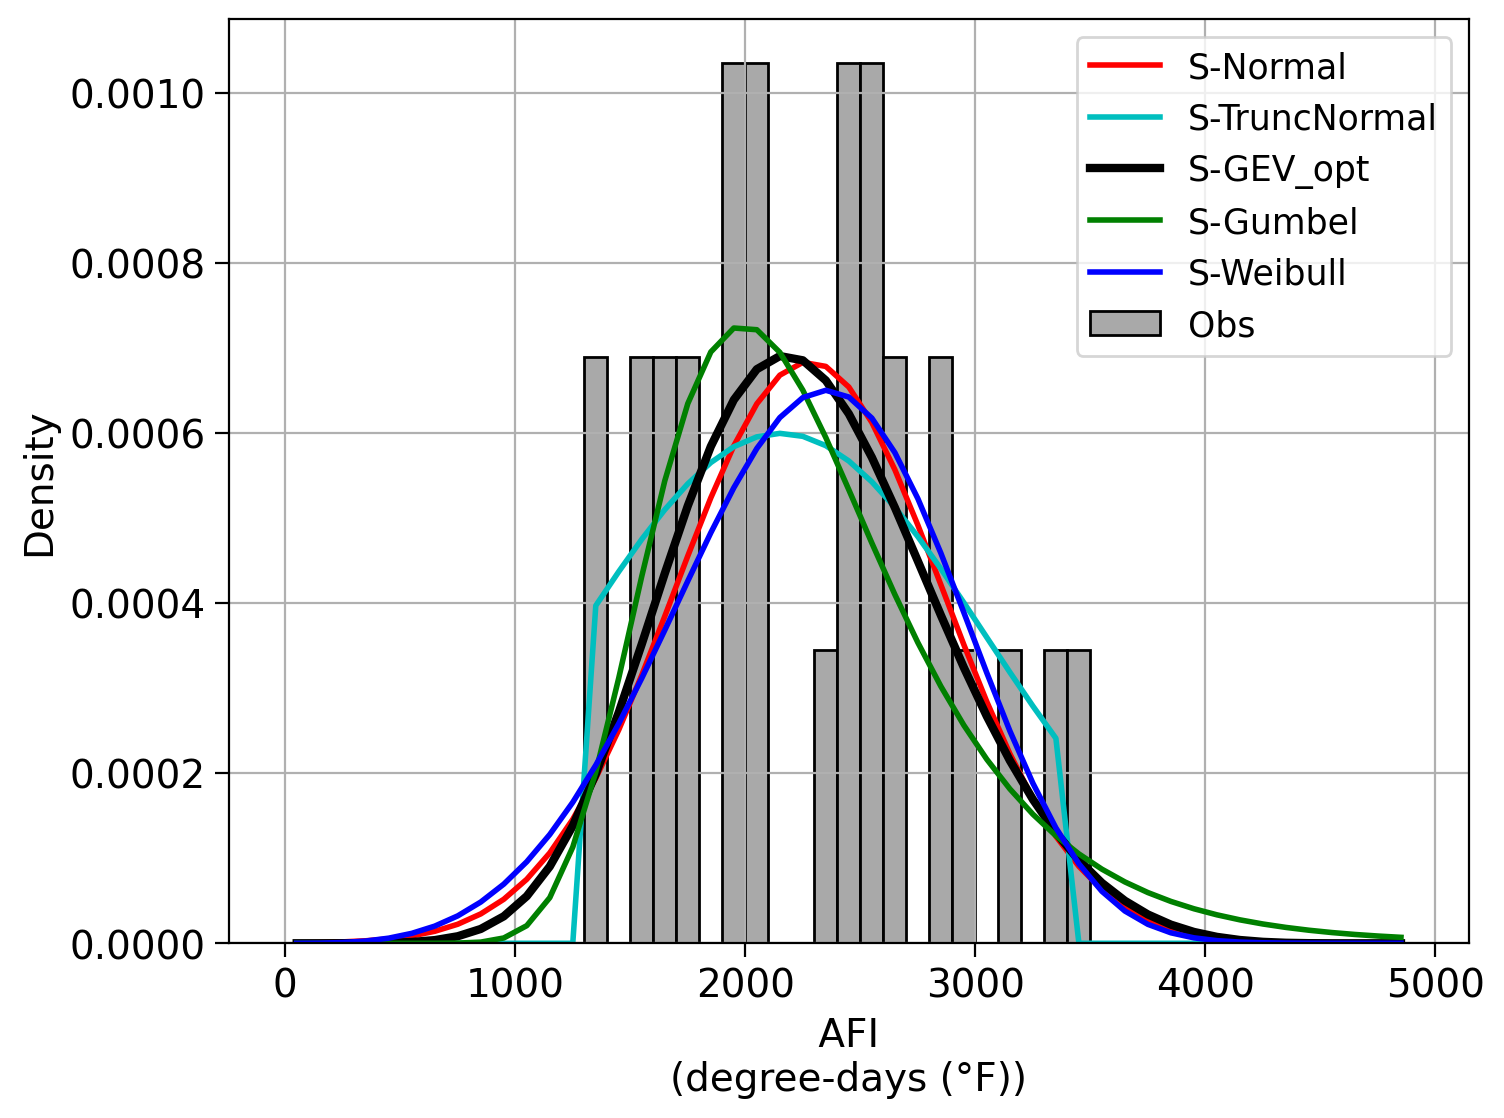

In [258]:
####
##### PDF Plot
#####

bins = np.arange(0,5000,100)
x100 = (bins[1:]+bins[:-1])*0.5


fig, ax= plt.subplots(nrows=1,ncols=1,figsize=(8,6))
dh=histogram(afi.where(afi>0), bins=bins,density=True, block_size=None)
ax.bar((bins[1:]+bins[:-1])*0.5,dh.data,edgecolor='k',color='darkgrey',\
          width=np.diff(bins), label='Obs')

# normal distribution
ax.plot(x100,stats.norm.pdf(x100, loc=nonzero_afis.mean(), scale=nonzero_afis.std()),
    c="r",lw=2,label="S-Normal")
# normal distribution
ax.plot(x100,stats.truncnorm.pdf(x100, *ptn),
    c="c",lw=2,label="S-TruncNormal")    
# GEV distribution
ax.plot(x100, gev.pdf(x100, *pgev), c="k", lw=3, label="S-GEV_opt")
# Gumbl distribution
ax.plot(x100, gev.pdf(x100, *pgum), c="g", lw=2, label="S-Gumbel")

# Weibul distribution
ax.plot(x100, stats.weibull_min(c_est, loc_est, scale_est).pdf(x100), c="b", lw=2, label="S-Weibull")

# calculate and plot the Gumbl distribution
shape, loc, scale = gev.fit(nonzero_afis,0)
ax.legend()
ax.grid()
ax.set_xlabel(f" AFI \n({units})",fontsize=14)
ax.set_ylabel("Density",fontsize=14)
ax.set_xticklabels(ax.get_xticklabels(),fontsize=14)
ax.set_yticklabels(ax.get_yticklabels(),fontsize=14)

Only Scipy function.

# Pt 2

In [259]:
ij=1
ilon=ptlon[ij]
ilat=ptlat[ij]
afi=ds['AFI'].sel(lon=ilon,lat=ilat).load()

In [260]:
# Extract AFI values
afi_values = afi.values
# Remove zeros if any (as in Bilotta et al.)
nonzero_afis = afi_values[afi_values > 0]

df = afi.where(afi>0).to_dataframe()
df=df.drop(columns=['lat','lon'])
df['year'] = df.index

# Convert pandas DataFrame to R data.frame
r_df = ro.conversion.py2rpy(df)

# You can now work with 'r_df' in R
print(ro.r['summary'](r_df))
globalenv['r_df'] = r_df

['Min.   :  0.6575  ' '1st Qu.:191.3118  ' 'Median :382.7024  '
 'Mean   :348.7907  ' '3rd Qu.:447.3997  ' 'Max.   :887.4810  '
 'Min.   :1980  ' '1st Qu.:1987  ' 'Median :1994  ' 'Mean   :1994  '
 '3rd Qu.:2001  ' 'Max.   :2008  ']


In [261]:
%R fitGEV <- fevd(AFI, data = r_df,type='GEV',method='MLE')
%R fitGumb <- fevd(AFI, data = r_df,type='Gumbel',method='MLE') # Gumbel shape=0
%R -o fitGEV,fitGumb

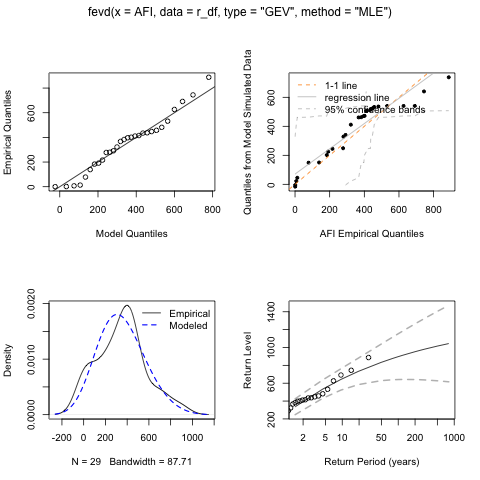

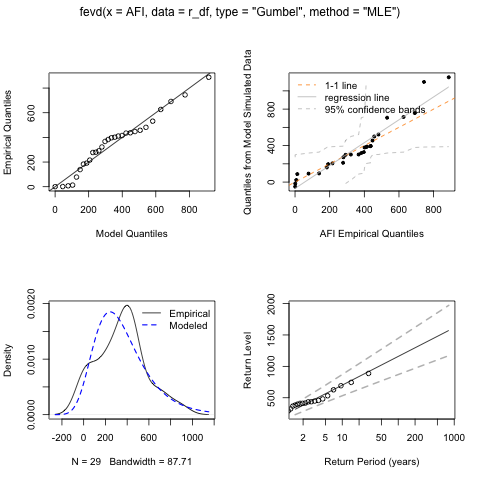

In [262]:
%R plot(fitGEV)
%R plot(fitGumb)

In [263]:
%R return_periods <- c( 1.1,1.6,2,3,4,5,6,7,8,9,10,15, 20,25, 50,75, 100, 200,500,750,1000)
%R rlGEV<-return.level(fitGEV, return.period = return_periods, make.plot=TRUE)
%R rlGumb<-return.level(fitGumb, return.period = return_periods, make.plot=TRUE)
%R -o rlGEV,rlGumb

<>:57: SyntaxWarning: invalid escape sequence '\d'
<>:57: SyntaxWarning: invalid escape sequence '\d'
<>:57: SyntaxWarning: invalid escape sequence '\d'
<>:57: SyntaxWarning: invalid escape sequence '\d'
/var/folders/2z/v4x6xdj96rg1k3xrmwt26xtc0000gp/T/ipykernel_36969/3103562804.py:57: SyntaxWarning: invalid escape sequence '\d'
  ax.set_title(f'{ilon}$\degree$E;{ilat}$\degree$N')
/var/folders/2z/v4x6xdj96rg1k3xrmwt26xtc0000gp/T/ipykernel_36969/3103562804.py:57: SyntaxWarning: invalid escape sequence '\d'
  ax.set_title(f'{ilon}$\degree$E;{ilat}$\degree$N')


Text(0.5, 1.0, '270$\\degree$E;40$\\degree$N')

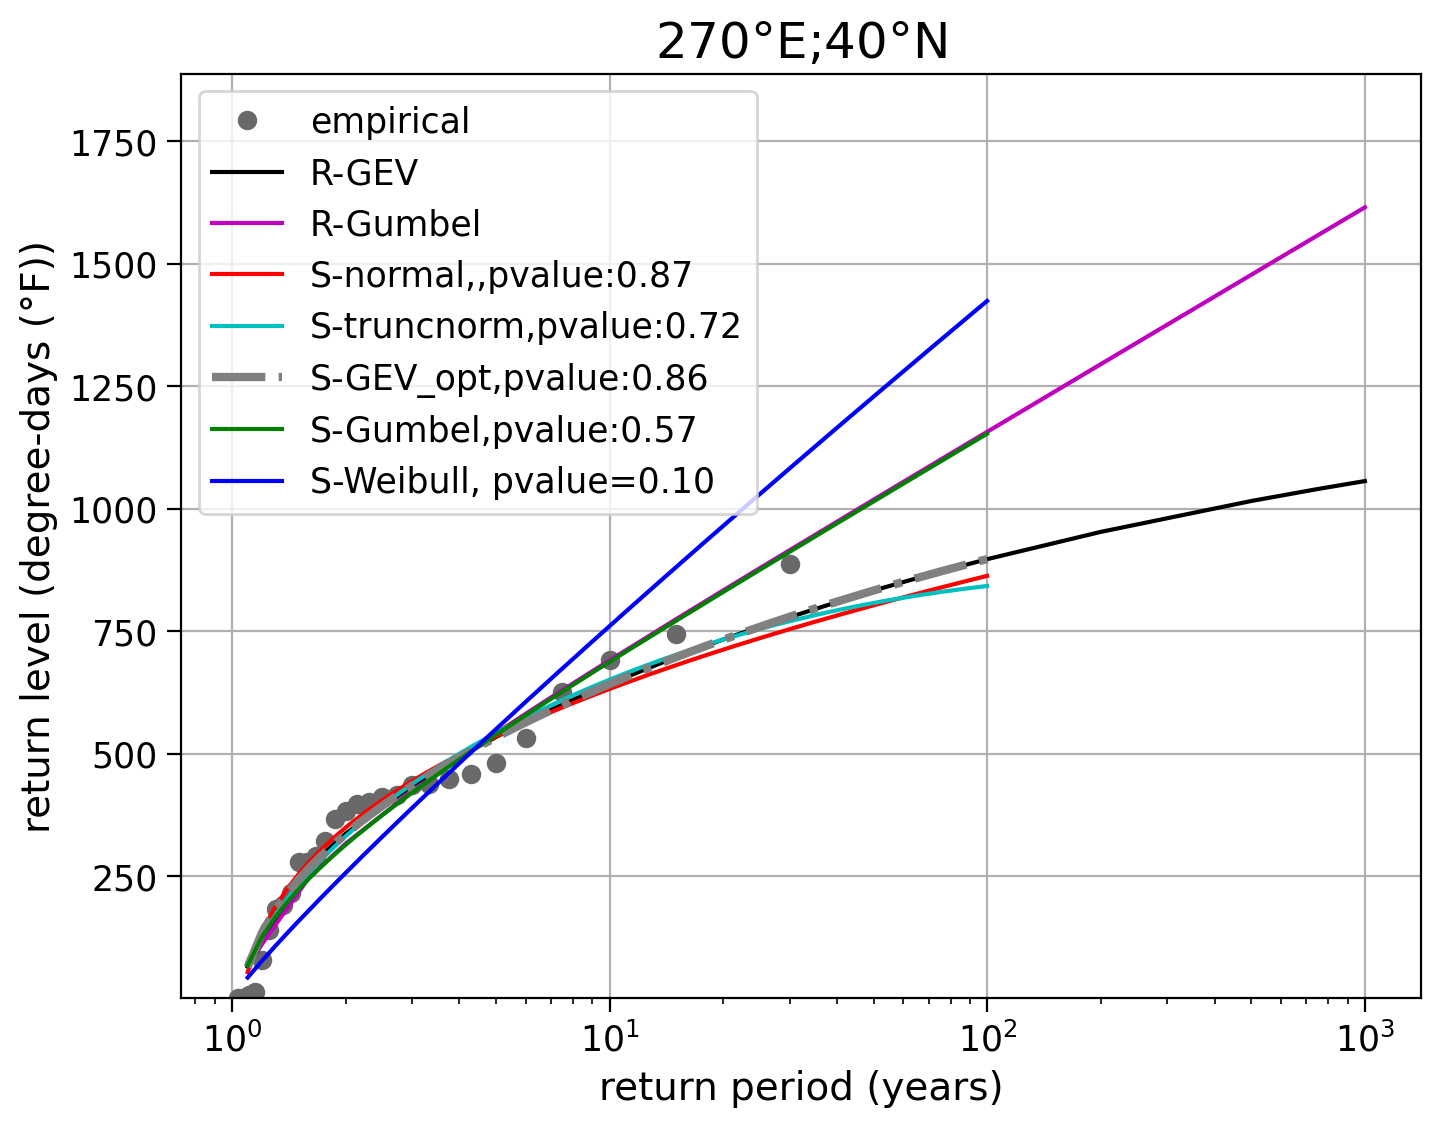

In [264]:

fig, ax = plt.subplots(nrows=1,ncols=1)
# plot empirical 
_ = empirical_return_level(nonzero_afis).plot(ax=ax, marker="o", color='dimgray',linestyle="None",label="empirical")

# plot R-distribution 
ax.plot(c,rlGEV,c='k',label='R-GEV')
ax.plot(c,rlGumb,c='m',label='R-Gumbel')


# calculate and plot the normal return levels
pv_n=np.round(stats.kstest(nonzero_afis,stats.norm.cdf, \
     args=(nonzero_afis.mean(),nonzero_afis.std()),N=ksN)[1],2)
ax.plot(years,stats.norm.ppf(1 - 1 / years, loc=nonzero_afis.mean(), scale=nonzero_afis.std())\
     ,c='r',label=f"S-normal,,pvalue:{pv_n}")

# calculate and plot the truncated gaussian return levels
loc_guess=nonzero_afis.mean()
scale_guess=nonzero_afis.std()
a_guess = (nonzero_afis.min() - loc_guess) / scale_guess
b_guess = (nonzero_afis.max() - loc_guess) / scale_guess

ptn = stats.truncnorm.fit(nonzero_afis,a_guess,b_guess,\
    scale= scale_guess, loc = loc_guess,  method='mle')
pv_tn=np.round(stats.kstest(nonzero_afis,stats.truncnorm.cdf, \
     args=ptn,N=ksN)[1],2)
ax.plot(years,stats.truncnorm.ppf(1 - 1 / years,*ptn),c='c',label=f"S-truncnorm,pvalue:{pv_tn}")

# calculate and plot the GEV distribution, optimized
pgev = gev.fit(nonzero_afis, method="MLE", optimizer=custom_optimizer)
pv_g= np.round(stats.kstest(nonzero_afis, 'genextreme', args=pgev, N=ksN)[1],2)
ax.plot(years, gev.ppf(1 - 1 / years, *pgev),c='grey',lw=3,ls='-.',label=f"S-GEV_opt,pvalue:{pv_g}")

# calculate and plot the Gumbel distribution
pgum = gev.fit(nonzero_afis,fc=0,method="MLE")# fc=0 fixes the shape parameter at 0
pv_gu= np.round(stats.kstest(nonzero_afis, 'genextreme', args=pgum, N=ksN)[1],2)
ax.plot(years, gev.ppf(1 - 1 / years,*pgum),c='g',label=f"S-Gumbel,pvalue:{pv_gu}")

# Weibul distribution
params = stats.weibull_min.fit(nonzero_afis, floc=0,optimizer=optimizer1) # floc=0 fixes the location parameter at 0
c_est, loc_est, scale_est = params
pv_w = stats.kstest(nonzero_afis, stats.weibull_min.name, params,N=ksN)[1]
ax.plot(years, stats.weibull_min(c_est, loc_est, scale_est).ppf(1 - 1 / years),c='b',label=f"S-Weibull, pvalue={pv_w:0.2f}")


#ax.set_xlim(0,100)
# set x axis to log scale
ax.set_xscale("log")

ax.set_ylabel(f'return level ({units})',fontsize=14)
ax.set_xlabel('return period (years)',fontsize=14)

ax.grid()
# set y axis lim
ax.set_ylim(nonzero_afis.min(),nonzero_afis.max()+1000.)
# show legend
ax.legend()
ax.set_title(f'{ilon}$\degree$E;{ilat}$\degree$N')

/var/folders/2z/v4x6xdj96rg1k3xrmwt26xtc0000gp/T/ipykernel_36969/2099759562.py:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(),fontsize=14)
/var/folders/2z/v4x6xdj96rg1k3xrmwt26xtc0000gp/T/ipykernel_36969/2099759562.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(),fontsize=14)


[Text(0, 0.0, '0.0000'),
 Text(0, 0.0005, '0.0005'),
 Text(0, 0.001, '0.0010'),
 Text(0, 0.0015, '0.0015'),
 Text(0, 0.002, '0.0020'),
 Text(0, 0.0025, '0.0025'),
 Text(0, 0.003, '0.0030')]

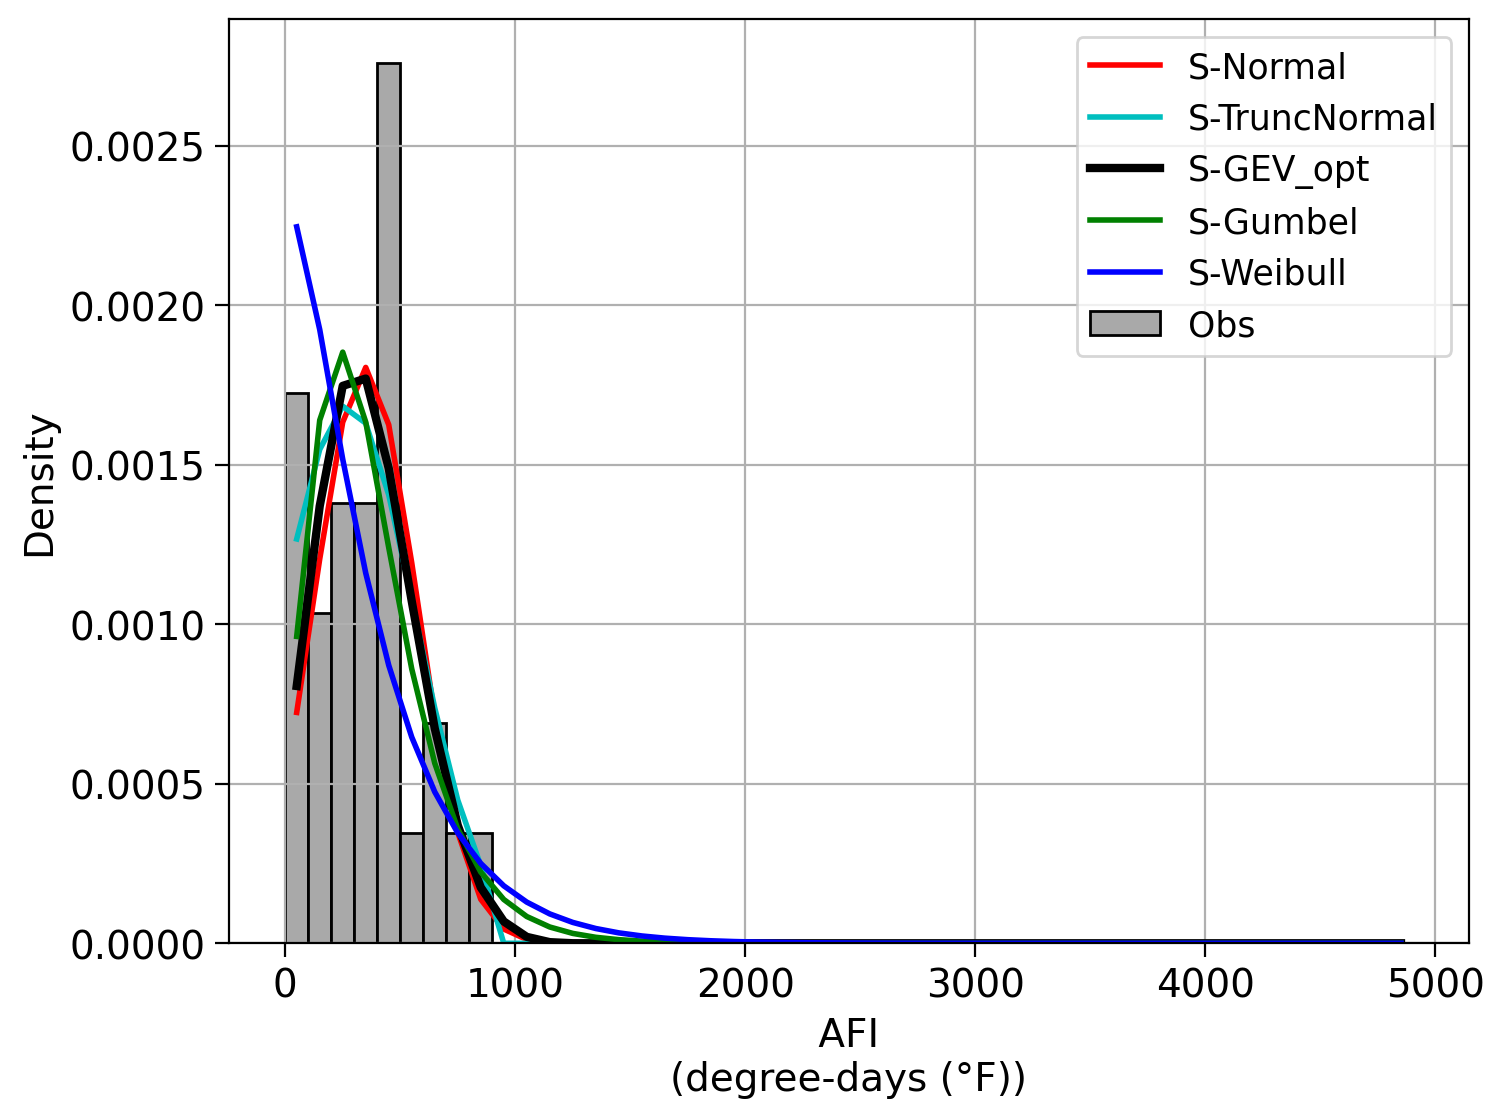

In [265]:
####
##### PDF Plot
#####

bins = np.arange(0,5000,100)
x100 = (bins[1:]+bins[:-1])*0.5
# create vector of years
years = np.arange(1.1, 100, 0.1)

fig, ax= plt.subplots(nrows=1,ncols=1,figsize=(8,6))
dh=histogram(afi.where(afi>0), bins=bins,density=True, block_size=None)
ax.bar((bins[1:]+bins[:-1])*0.5,dh.data,edgecolor='k',color='darkgrey',\
          width=np.diff(bins), label='Obs')

# normal distribution
ax.plot(x100,stats.norm.pdf(x100, loc=nonzero_afis.mean(), scale=nonzero_afis.std()),
    c="r",lw=2,label="S-Normal")
# normal distribution
ax.plot(x100,stats.truncnorm.pdf(x100, *ptn),
    c="c",lw=2,label="S-TruncNormal")    
# GEV distribution
ax.plot(x100, gev.pdf(x100, *pgev), c="k", lw=3, label="S-GEV_opt")
# Gumbl distribution
ax.plot(x100, gev.pdf(x100, *pgum), c="g", lw=2, label="S-Gumbel")

# Weibul distribution
ax.plot(x100, stats.weibull_min(c_est, loc_est, scale_est).pdf(x100), c="b", lw=2, label="S-Weibull")

# calculate and plot the Gumbl distribution
shape, loc, scale = gev.fit(nonzero_afis,0)
ax.legend()
ax.grid()
ax.set_xlabel(f" AFI \n({units})",fontsize=14)
ax.set_ylabel("Density",fontsize=14)
ax.set_xticklabels(ax.get_xticklabels(),fontsize=14)
ax.set_yticklabels(ax.get_yticklabels(),fontsize=14)

# Pt 3

In [266]:
ij=2
ilon=ptlon[ij]
ilat=ptlat[ij]
afi=ds['AFI'].sel(lon=ilon,lat=ilat).load()

# Extract AFI values
afi_values = afi.values
# Remove zeros if any (as in Bilotta et al.)
nonzero_afis = afi_values[afi_values > 0]

df = afi.where(afi>0).to_dataframe()
df=df.drop(columns=['lat','lon'])
df['year'] = df.index

# Convert pandas DataFrame to R data.frame
r_df = ro.conversion.py2rpy(df)

# You can now work with 'r_df' in R
print(ro.r['summary'](r_df))
globalenv['r_df'] = r_df

['Min.   :  0.2676  ' '1st Qu.:  2.3877  ' 'Median :  6.4619  '
 'Mean   : 67.9923  ' '3rd Qu.: 70.4429  ' 'Max.   :488.7080  '
 'Min.   :1980  ' '1st Qu.:1987  ' 'Median :1994  ' 'Mean   :1994  '
 '3rd Qu.:2001  ' 'Max.   :2008  ']


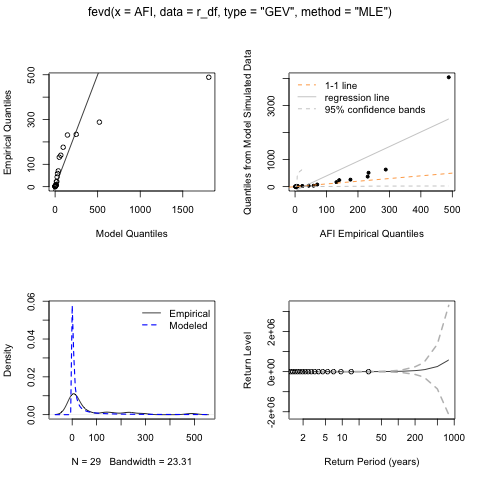

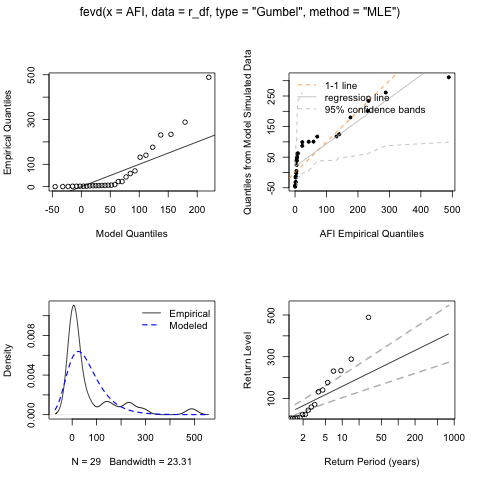

In [267]:
%R fitGEV <- fevd(AFI, data = r_df,type='GEV',method='MLE')
%R fitGumb <- fevd(AFI, data = r_df,type='Gumbel',method='MLE') # Gumbel shape=0
%R -o fitGEV,fitGumb
%R plot(fitGEV)
%R plot(fitGumb)

In [268]:
%R return_periods <- c(1.1,1.6,2,3,4,5,6,7,8,9,10,15, 20,25, 50,75, 100, 200,500,750,1000)
%R rlGEV<-return.level(fitGEV, return.period = return_periods, make.plot=TRUE)
%R rlGumb<-return.level(fitGumb, return.period = return_periods, make.plot=TRUE)
%R -o rlGEV,rlGumb



<>:57: SyntaxWarning: invalid escape sequence '\d'
<>:57: SyntaxWarning: invalid escape sequence '\d'
<>:57: SyntaxWarning: invalid escape sequence '\d'
<>:57: SyntaxWarning: invalid escape sequence '\d'
/var/folders/2z/v4x6xdj96rg1k3xrmwt26xtc0000gp/T/ipykernel_36969/3103562804.py:57: SyntaxWarning: invalid escape sequence '\d'
  ax.set_title(f'{ilon}$\degree$E;{ilat}$\degree$N')
/var/folders/2z/v4x6xdj96rg1k3xrmwt26xtc0000gp/T/ipykernel_36969/3103562804.py:57: SyntaxWarning: invalid escape sequence '\d'
  ax.set_title(f'{ilon}$\degree$E;{ilat}$\degree$N')


Text(0.5, 1.0, '264.25$\\degree$E;37$\\degree$N')

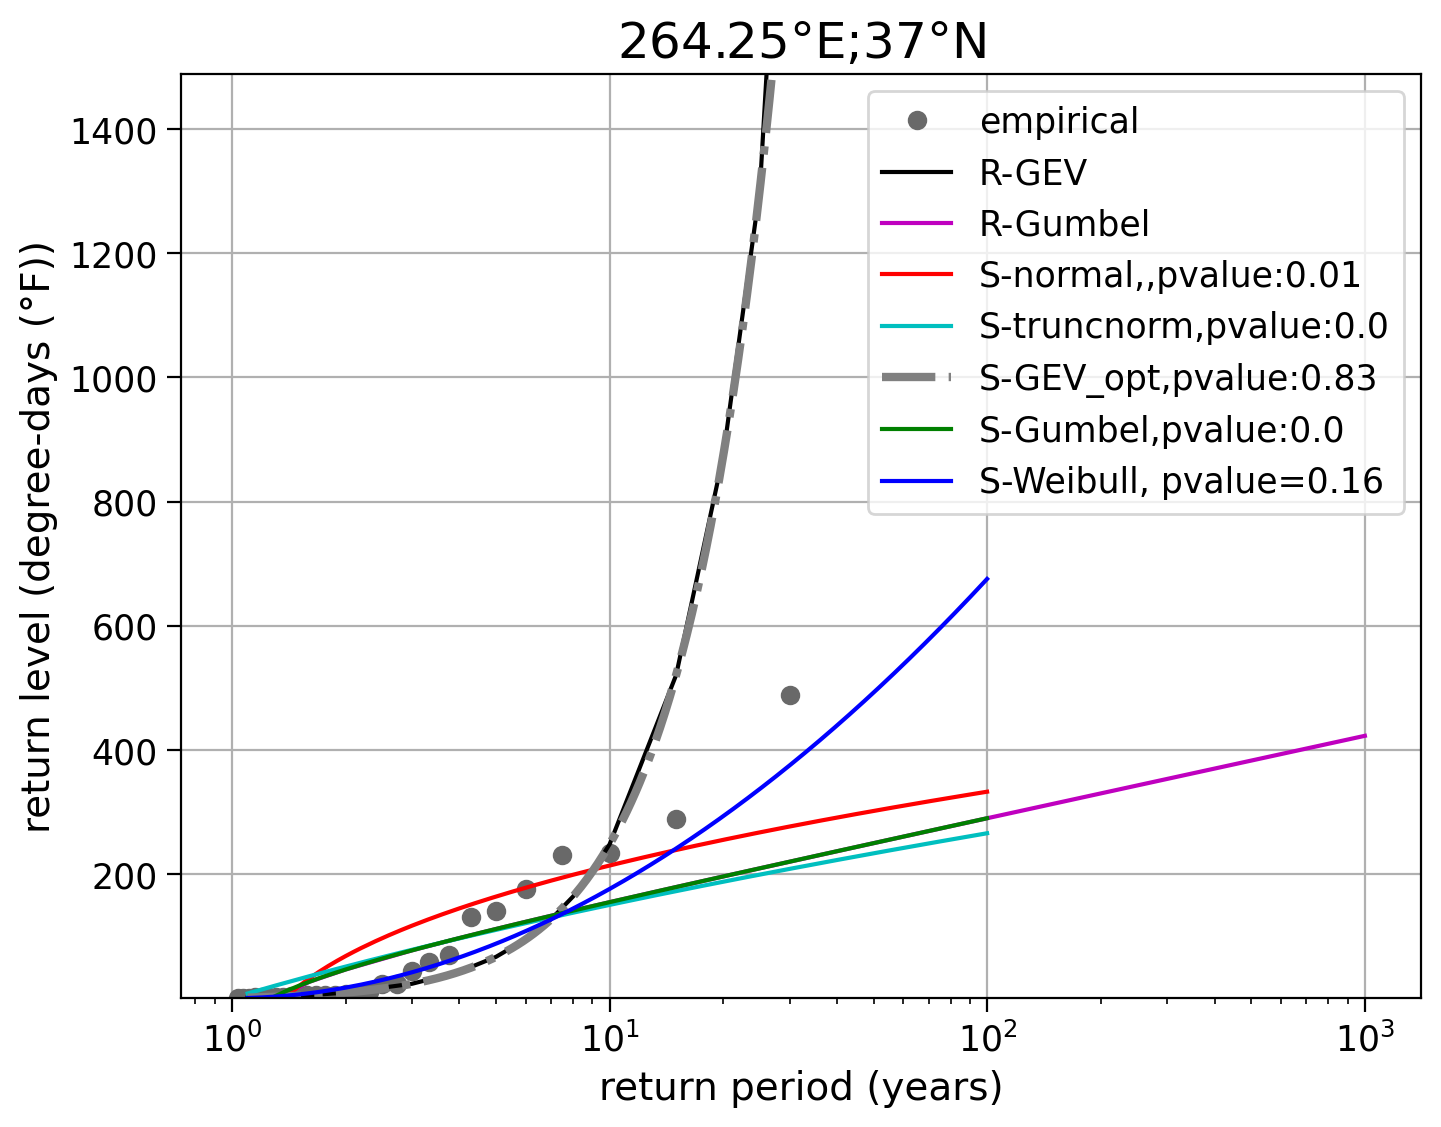

In [269]:

fig, ax = plt.subplots(nrows=1,ncols=1)
# plot empirical 
_ = empirical_return_level(nonzero_afis).plot(ax=ax, marker="o", color='dimgray',linestyle="None",label="empirical")

# plot R-distribution 
ax.plot(c,rlGEV,c='k',label='R-GEV')
ax.plot(c,rlGumb,c='m',label='R-Gumbel')


# calculate and plot the normal return levels
pv_n=np.round(stats.kstest(nonzero_afis,stats.norm.cdf, \
     args=(nonzero_afis.mean(),nonzero_afis.std()),N=ksN)[1],2)
ax.plot(years,stats.norm.ppf(1 - 1 / years, loc=nonzero_afis.mean(), scale=nonzero_afis.std())\
     ,c='r',label=f"S-normal,,pvalue:{pv_n}")

# calculate and plot the truncated gaussian return levels
loc_guess=nonzero_afis.mean()
scale_guess=nonzero_afis.std()
a_guess = (nonzero_afis.min() - loc_guess) / scale_guess
b_guess = (nonzero_afis.max() - loc_guess) / scale_guess

ptn = stats.truncnorm.fit(nonzero_afis,a_guess,b_guess,\
    scale= scale_guess, loc = loc_guess,  method='mle')
pv_tn=np.round(stats.kstest(nonzero_afis,stats.truncnorm.cdf, \
     args=ptn,N=ksN)[1],2)
ax.plot(years,stats.truncnorm.ppf(1 - 1 / years,*ptn),c='c',label=f"S-truncnorm,pvalue:{pv_tn}")

# calculate and plot the GEV distribution, optimized
pgev = gev.fit(nonzero_afis, method="MLE", optimizer=custom_optimizer)
pv_g= np.round(stats.kstest(nonzero_afis, 'genextreme', args=pgev, N=ksN)[1],2)
ax.plot(years, gev.ppf(1 - 1 / years, *pgev),c='grey',lw=3,ls='-.',label=f"S-GEV_opt,pvalue:{pv_g}")

# calculate and plot the Gumbel distribution
pgum = gev.fit(nonzero_afis,fc=0,method="MLE")# fc=0 fixes the shape parameter at 0
pv_gu= np.round(stats.kstest(nonzero_afis, 'genextreme', args=pgum, N=ksN)[1],2)
ax.plot(years, gev.ppf(1 - 1 / years,*pgum),c='g',label=f"S-Gumbel,pvalue:{pv_gu}")

# Weibul distribution
params = stats.weibull_min.fit(nonzero_afis, floc=0,optimizer=optimizer1) # floc=0 fixes the location parameter at 0
c_est, loc_est, scale_est = params
pv_w = stats.kstest(nonzero_afis, stats.weibull_min.name, params,N=ksN)[1]
ax.plot(years, stats.weibull_min(c_est, loc_est, scale_est).ppf(1 - 1 / years),c='b',label=f"S-Weibull, pvalue={pv_w:0.2f}")


#ax.set_xlim(0,100)
# set x axis to log scale
ax.set_xscale("log")

ax.set_ylabel(f'return level ({units})',fontsize=14)
ax.set_xlabel('return period (years)',fontsize=14)

ax.grid()
# set y axis lim
ax.set_ylim(nonzero_afis.min(),nonzero_afis.max()+1000.)
# show legend
ax.legend()
ax.set_title(f'{ilon}$\degree$E;{ilat}$\degree$N')

/var/folders/2z/v4x6xdj96rg1k3xrmwt26xtc0000gp/T/ipykernel_36969/2099759562.py:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(),fontsize=14)
/var/folders/2z/v4x6xdj96rg1k3xrmwt26xtc0000gp/T/ipykernel_36969/2099759562.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(),fontsize=14)


[Text(0, 0.0, '0.000'),
 Text(0, 0.001, '0.001'),
 Text(0, 0.002, '0.002'),
 Text(0, 0.003, '0.003'),
 Text(0, 0.004, '0.004'),
 Text(0, 0.005, '0.005'),
 Text(0, 0.006, '0.006'),
 Text(0, 0.007, '0.007'),
 Text(0, 0.008, '0.008')]

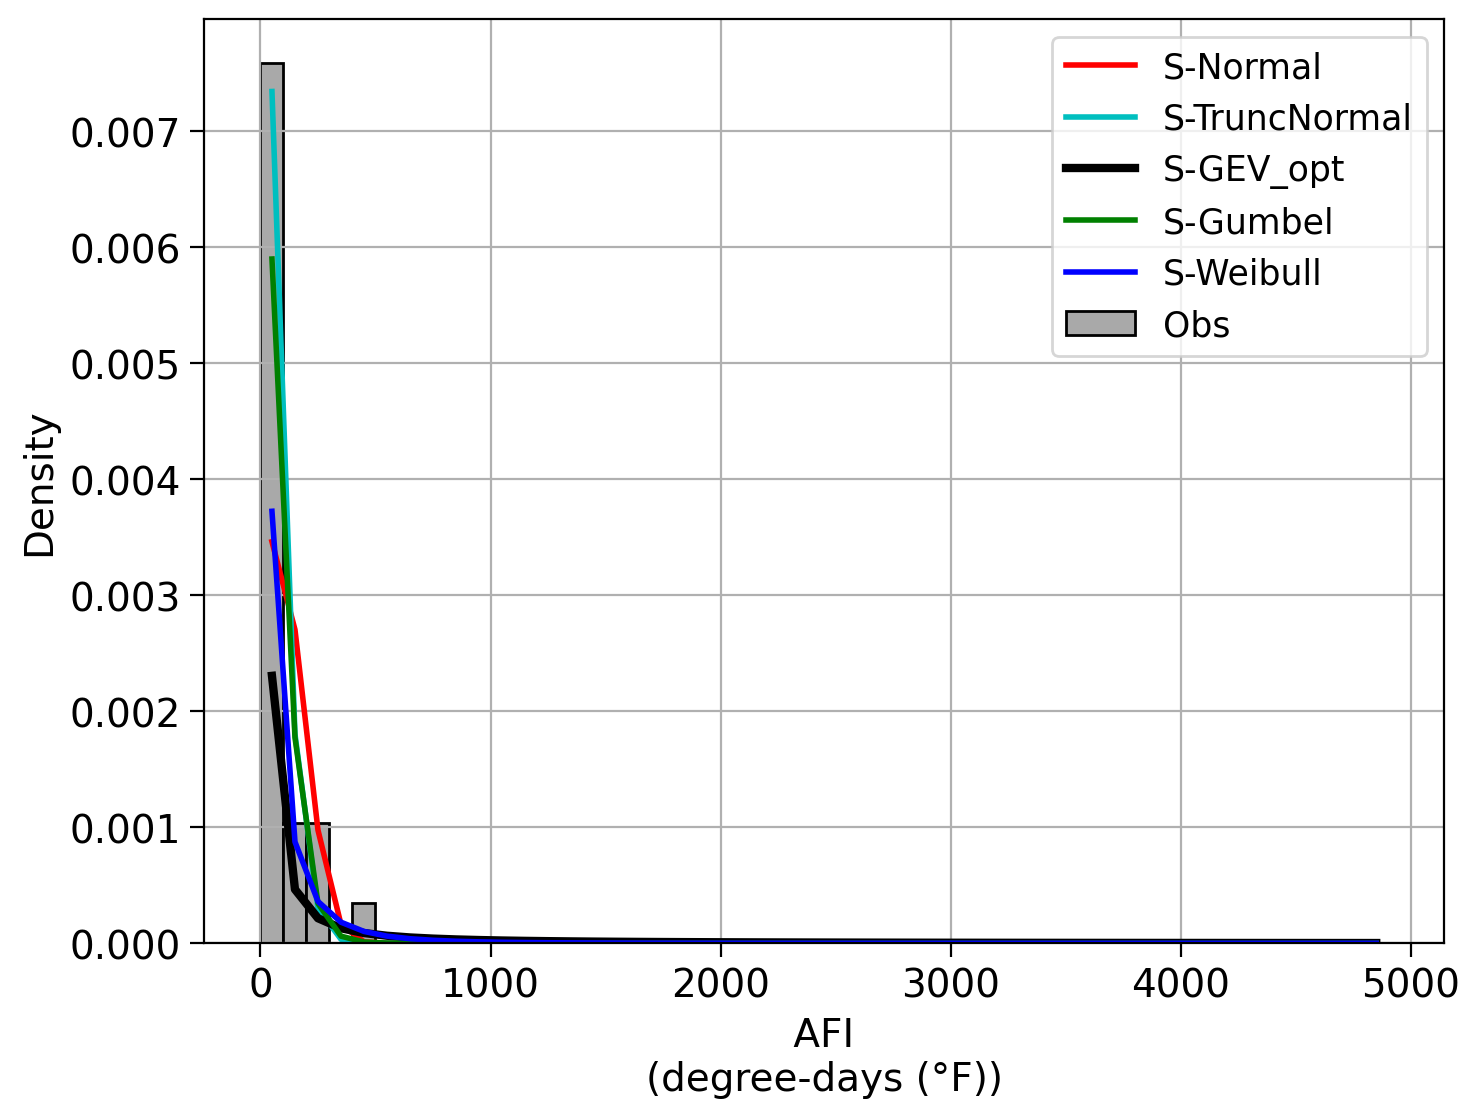

In [270]:
####
##### PDF Plot
#####

bins = np.arange(0,5000,100)
x100 = (bins[1:]+bins[:-1])*0.5
# create vector of years
years = np.arange(1.1, 100, 0.1)

fig, ax= plt.subplots(nrows=1,ncols=1,figsize=(8,6))
dh=histogram(afi.where(afi>0), bins=bins,density=True, block_size=None)
ax.bar((bins[1:]+bins[:-1])*0.5,dh.data,edgecolor='k',color='darkgrey',\
          width=np.diff(bins), label='Obs')

# normal distribution
ax.plot(x100,stats.norm.pdf(x100, loc=nonzero_afis.mean(), scale=nonzero_afis.std()),
    c="r",lw=2,label="S-Normal")
# normal distribution
ax.plot(x100,stats.truncnorm.pdf(x100, *ptn),
    c="c",lw=2,label="S-TruncNormal")    
# GEV distribution
ax.plot(x100, gev.pdf(x100, *pgev), c="k", lw=3, label="S-GEV_opt")
# Gumbl distribution
ax.plot(x100, gev.pdf(x100, *pgum), c="g", lw=2, label="S-Gumbel")

# Weibul distribution
ax.plot(x100, stats.weibull_min(c_est, loc_est, scale_est).pdf(x100), c="b", lw=2, label="S-Weibull")

# calculate and plot the Gumbl distribution
shape, loc, scale = gev.fit(nonzero_afis,0)
ax.legend()
ax.grid()
ax.set_xlabel(f" AFI \n({units})",fontsize=14)
ax.set_ylabel("Density",fontsize=14)
ax.set_xticklabels(ax.get_xticklabels(),fontsize=14)
ax.set_yticklabels(ax.get_yticklabels(),fontsize=14)

# Pt 4

In [271]:
ij=3
ilon=ptlon[ij]
ilat=ptlat[ij]
afi=ds['AFI'].sel(lon=ilon,lat=ilat).load()

# Extract AFI values
afi_values = afi.values
# Remove zeros if any (as in Bilotta et al.)
nonzero_afis = afi_values[afi_values > 0]

df = afi.where(afi>0).to_dataframe()
df=df.drop(columns=['lat','lon'])
df['year'] = df.index

# Convert pandas DataFrame to R data.frame
r_df = ro.conversion.py2rpy(df)

# You can now work with 'r_df' in R
print(ro.r['summary'](r_df))
globalenv['r_df'] = r_df

['Min.   :  0.4282  ' '1st Qu.:  2.3760  ' 'Median : 26.8005  '
 'Mean   :118.7921  ' '3rd Qu.:223.0945  ' 'Max.   :812.9270  '
 'Min.   :1980  ' '1st Qu.:1987  ' 'Median :1994  ' 'Mean   :1994  '
 '3rd Qu.:2001  ' 'Max.   :2008  ']


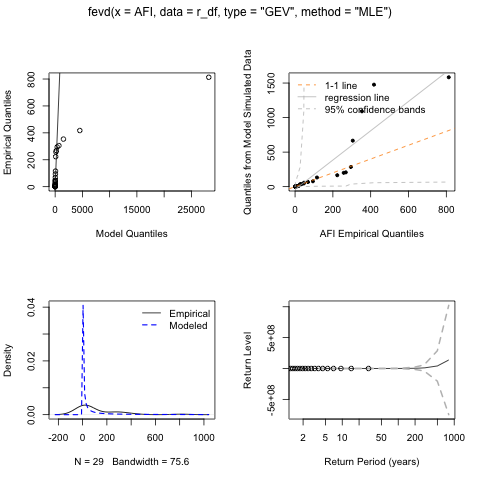

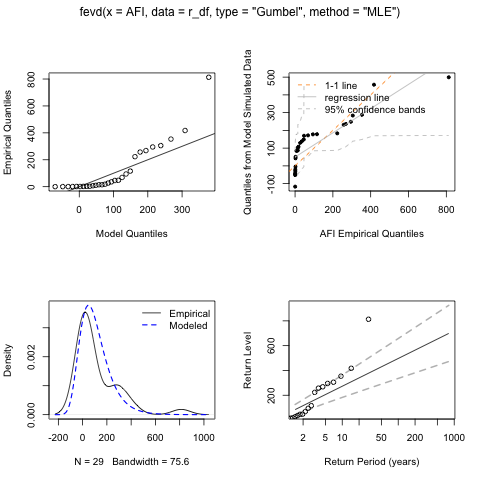

In [272]:
%R fitGEV <- fevd(AFI, data = r_df,type='GEV',method='MLE')
%R fitGumb <- fevd(AFI, data = r_df,type='Gumbel',method='MLE') # Gumbel shape=0
%R -o fitGEV,fitGumb
%R plot(fitGEV)
%R plot(fitGumb)

In [273]:
%R return_periods <- c(1.1,1.6,2,3,4,5,6,7,8,9,10,15, 20,25, 50,75, 100, 200,500,750,1000)
%R rlGEV<-return.level(fitGEV, return.period = return_periods, make.plot=TRUE)
%R rlGumb<-return.level(fitGumb, return.period = return_periods, make.plot=TRUE)
%R -o rlGEV,rlGumb



<>:57: SyntaxWarning: invalid escape sequence '\d'
<>:57: SyntaxWarning: invalid escape sequence '\d'
<>:57: SyntaxWarning: invalid escape sequence '\d'
<>:57: SyntaxWarning: invalid escape sequence '\d'
/var/folders/2z/v4x6xdj96rg1k3xrmwt26xtc0000gp/T/ipykernel_36969/3103562804.py:57: SyntaxWarning: invalid escape sequence '\d'
  ax.set_title(f'{ilon}$\degree$E;{ilat}$\degree$N')
/var/folders/2z/v4x6xdj96rg1k3xrmwt26xtc0000gp/T/ipykernel_36969/3103562804.py:57: SyntaxWarning: invalid escape sequence '\d'
  ax.set_title(f'{ilon}$\degree$E;{ilat}$\degree$N')


Text(0.5, 1.0, '241$\\degree$E;46.25$\\degree$N')

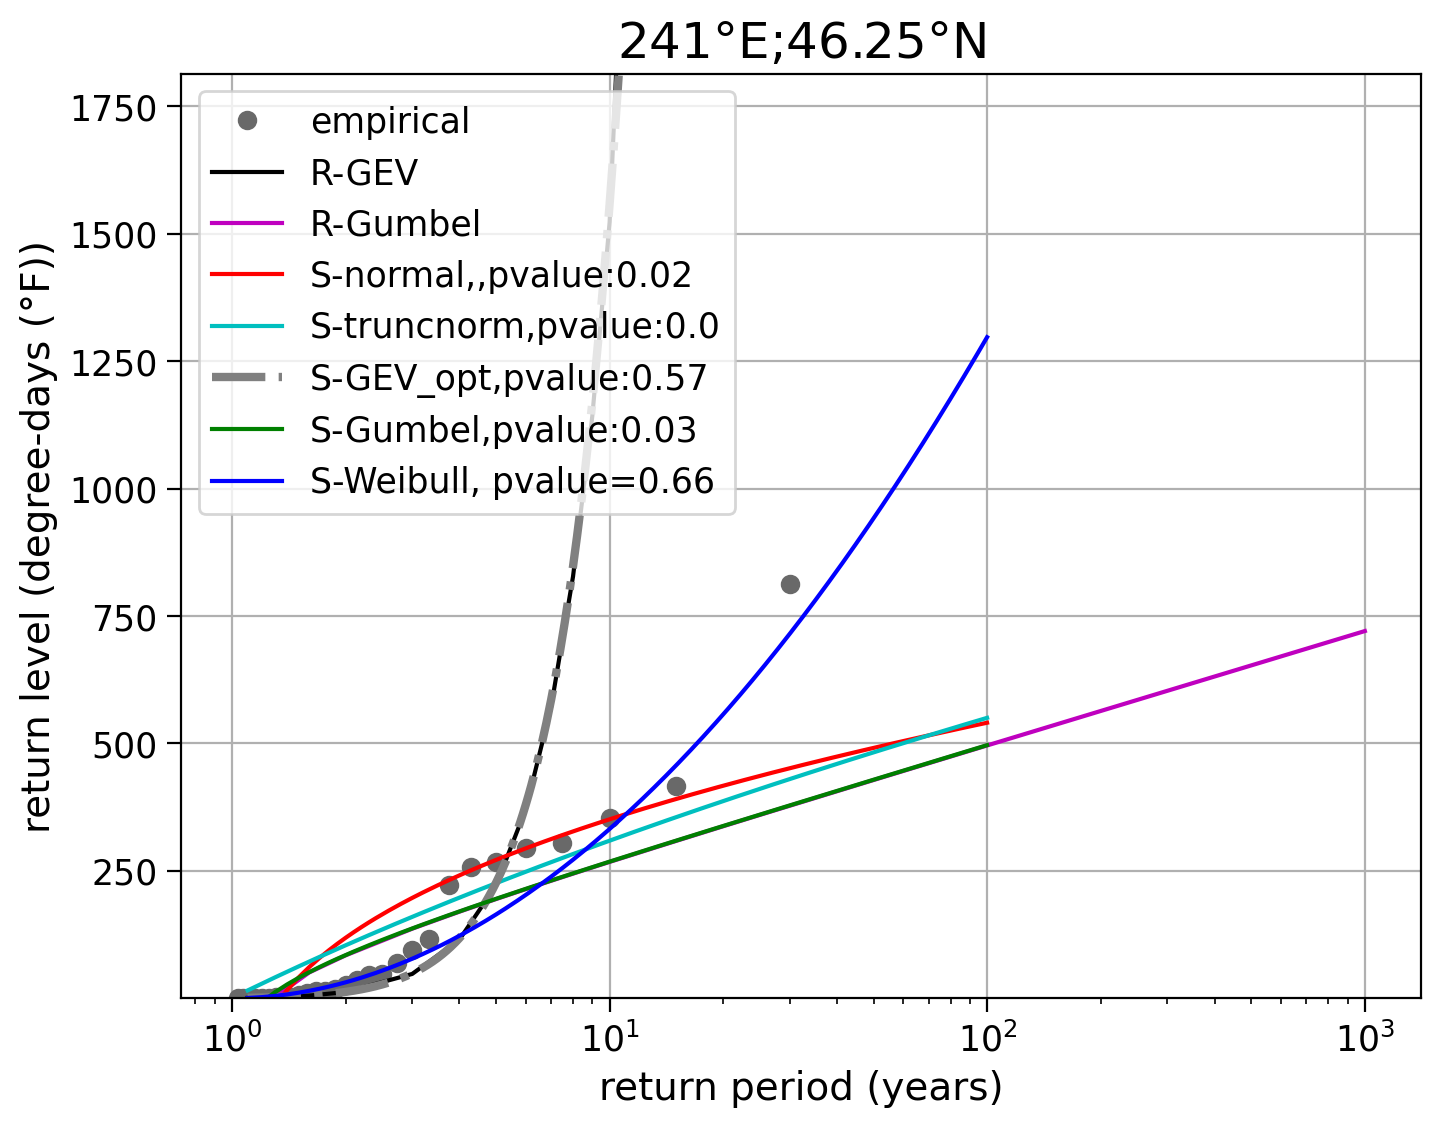

In [274]:

fig, ax = plt.subplots(nrows=1,ncols=1)
# plot empirical 
_ = empirical_return_level(nonzero_afis).plot(ax=ax, marker="o", color='dimgray',linestyle="None",label="empirical")

# plot R-distribution 
ax.plot(c,rlGEV,c='k',label='R-GEV')
ax.plot(c,rlGumb,c='m',label='R-Gumbel')


# calculate and plot the normal return levels
pv_n=np.round(stats.kstest(nonzero_afis,stats.norm.cdf, \
     args=(nonzero_afis.mean(),nonzero_afis.std()),N=ksN)[1],2)
ax.plot(years,stats.norm.ppf(1 - 1 / years, loc=nonzero_afis.mean(), scale=nonzero_afis.std())\
     ,c='r',label=f"S-normal,,pvalue:{pv_n}")

# calculate and plot the truncated gaussian return levels
loc_guess=nonzero_afis.mean()
scale_guess=nonzero_afis.std()
a_guess = (nonzero_afis.min() - loc_guess) / scale_guess
b_guess = (nonzero_afis.max() - loc_guess) / scale_guess

ptn = stats.truncnorm.fit(nonzero_afis,a_guess,b_guess,\
    scale= scale_guess, loc = loc_guess,  method='mle')
pv_tn=np.round(stats.kstest(nonzero_afis,stats.truncnorm.cdf, \
     args=ptn,N=ksN)[1],2)
ax.plot(years,stats.truncnorm.ppf(1 - 1 / years,*ptn),c='c',label=f"S-truncnorm,pvalue:{pv_tn}")

# calculate and plot the GEV distribution, optimized
pgev = gev.fit(nonzero_afis, method="MLE", optimizer=custom_optimizer)
pv_g= np.round(stats.kstest(nonzero_afis, 'genextreme', args=pgev, N=ksN)[1],2)
ax.plot(years, gev.ppf(1 - 1 / years, *pgev),c='grey',lw=3,ls='-.',label=f"S-GEV_opt,pvalue:{pv_g}")

# calculate and plot the Gumbel distribution
pgum = gev.fit(nonzero_afis,fc=0,method="MLE")# fc=0 fixes the shape parameter at 0
pv_gu= np.round(stats.kstest(nonzero_afis, 'genextreme', args=pgum, N=ksN)[1],2)
ax.plot(years, gev.ppf(1 - 1 / years,*pgum),c='g',label=f"S-Gumbel,pvalue:{pv_gu}")

# Weibul distribution
params = stats.weibull_min.fit(nonzero_afis, floc=0,optimizer=optimizer1) # floc=0 fixes the location parameter at 0
c_est, loc_est, scale_est = params
pv_w = stats.kstest(nonzero_afis, stats.weibull_min.name, params,N=ksN)[1]
ax.plot(years, stats.weibull_min(c_est, loc_est, scale_est).ppf(1 - 1 / years),c='b',label=f"S-Weibull, pvalue={pv_w:0.2f}")


#ax.set_xlim(0,100)
# set x axis to log scale
ax.set_xscale("log")

ax.set_ylabel(f'return level ({units})',fontsize=14)
ax.set_xlabel('return period (years)',fontsize=14)

ax.grid()
# set y axis lim
ax.set_ylim(nonzero_afis.min(),nonzero_afis.max()+1000.)
# show legend
ax.legend()
ax.set_title(f'{ilon}$\degree$E;{ilat}$\degree$N')

/var/folders/2z/v4x6xdj96rg1k3xrmwt26xtc0000gp/T/ipykernel_36969/2099759562.py:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(),fontsize=14)
/var/folders/2z/v4x6xdj96rg1k3xrmwt26xtc0000gp/T/ipykernel_36969/2099759562.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(),fontsize=14)


[Text(0, 0.0, '0.000'),
 Text(0, 0.001, '0.001'),
 Text(0, 0.002, '0.002'),
 Text(0, 0.003, '0.003'),
 Text(0, 0.004, '0.004'),
 Text(0, 0.005, '0.005'),
 Text(0, 0.006, '0.006'),
 Text(0, 0.007, '0.007'),
 Text(0, 0.008, '0.008')]

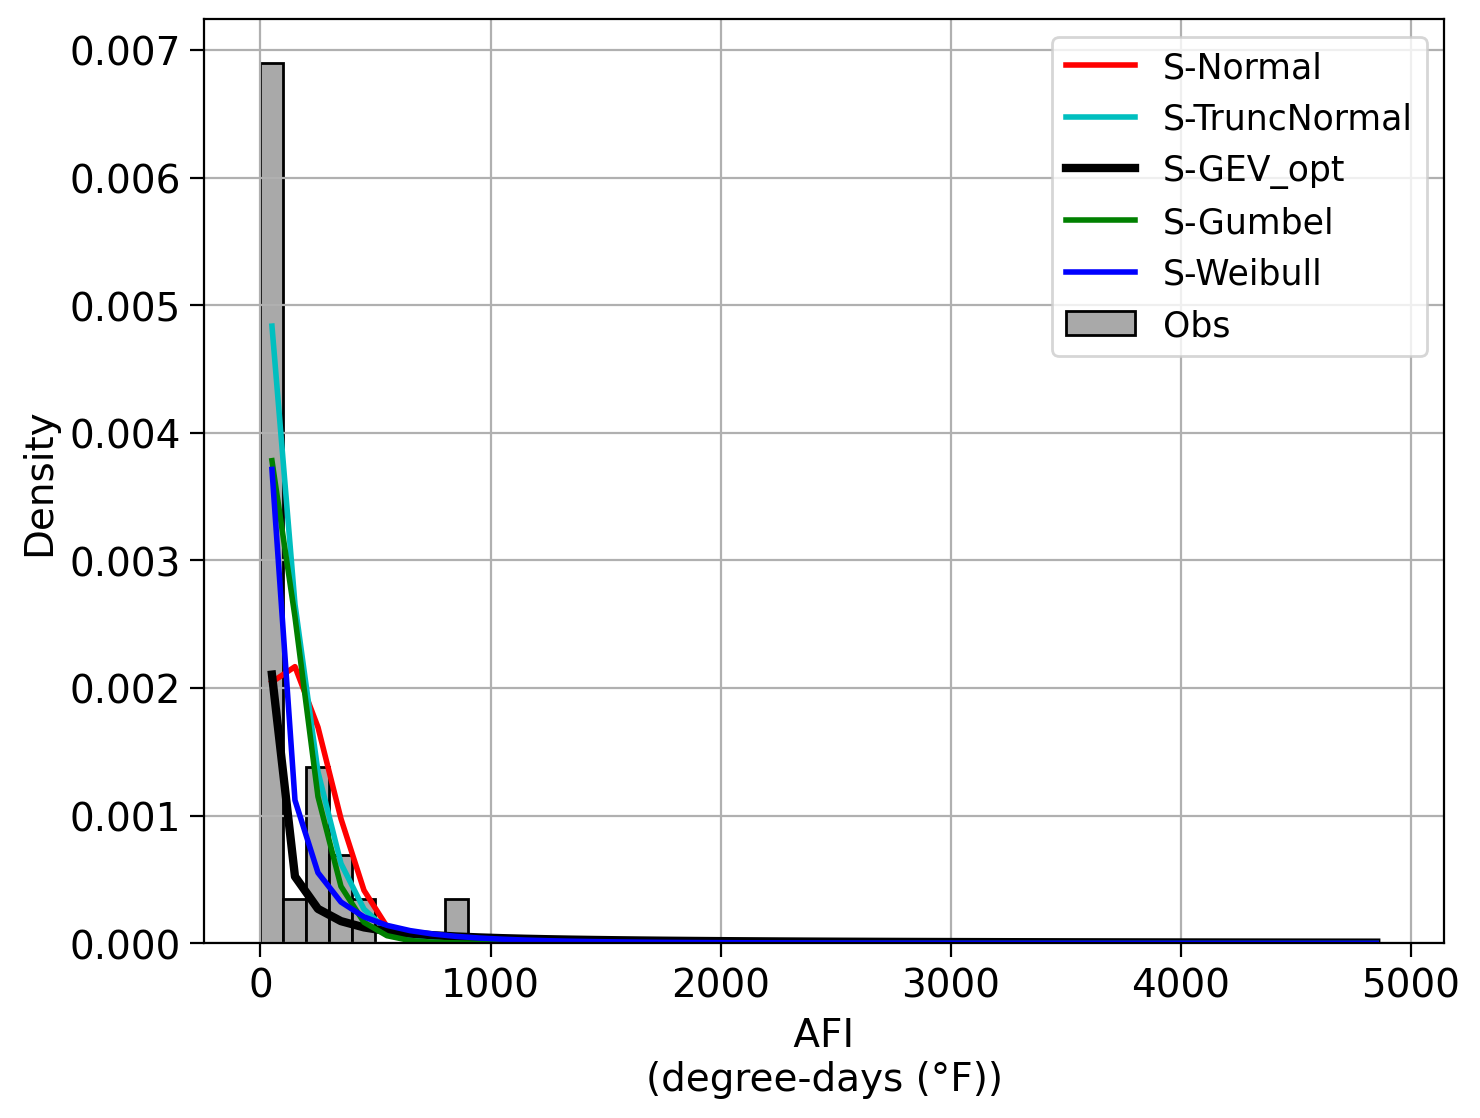

In [275]:
####
##### PDF Plot
#####

bins = np.arange(0,5000,100)
x100 = (bins[1:]+bins[:-1])*0.5
# create vector of years
years = np.arange(1.1, 100, 0.1)

fig, ax= plt.subplots(nrows=1,ncols=1,figsize=(8,6))
dh=histogram(afi.where(afi>0), bins=bins,density=True, block_size=None)
ax.bar((bins[1:]+bins[:-1])*0.5,dh.data,edgecolor='k',color='darkgrey',\
          width=np.diff(bins), label='Obs')

# normal distribution
ax.plot(x100,stats.norm.pdf(x100, loc=nonzero_afis.mean(), scale=nonzero_afis.std()),
    c="r",lw=2,label="S-Normal")
# normal distribution
ax.plot(x100,stats.truncnorm.pdf(x100, *ptn),
    c="c",lw=2,label="S-TruncNormal")    
# GEV distribution
ax.plot(x100, gev.pdf(x100, *pgev), c="k", lw=3, label="S-GEV_opt")
# Gumbl distribution
ax.plot(x100, gev.pdf(x100, *pgum), c="g", lw=2, label="S-Gumbel")

# Weibul distribution
ax.plot(x100, stats.weibull_min(c_est, loc_est, scale_est).pdf(x100), c="b", lw=2, label="S-Weibull")

# calculate and plot the Gumbl distribution
shape, loc, scale = gev.fit(nonzero_afis,0)
ax.legend()
ax.grid()
ax.set_xlabel(f" AFI \n({units})",fontsize=14)
ax.set_ylabel("Density",fontsize=14)
ax.set_xticklabels(ax.get_xticklabels(),fontsize=14)
ax.set_yticklabels(ax.get_yticklabels(),fontsize=14)

# Pt 5

In [276]:
ij=4
ilon=ptlon[ij]
ilat=ptlat[ij]
afi=ds['AFI'].sel(lon=ilon,lat=ilat).load()

# Extract AFI values
afi_values = afi.values
# Remove zeros if any (as in Bilotta et al.)
nonzero_afis = afi_values[afi_values > 0]

df = afi.where(afi>0).to_dataframe()
df=df.drop(columns=['lat','lon'])
df['year'] = df.index

# Convert pandas DataFrame to R data.frame
r_df = ro.conversion.py2rpy(df)

# You can now work with 'r_df' in R
print(ro.r['summary'](r_df))
globalenv['r_df'] = r_df

['Min.   :7280  ' '1st Qu.:8224  ' 'Median :8369  ' 'Mean   :8550  '
 '3rd Qu.:8914  ' 'Max.   :9941  ' 'Min.   :1980  ' '1st Qu.:1987  '
 'Median :1994  ' 'Mean   :1994  ' '3rd Qu.:2001  ' 'Max.   :2008  ']


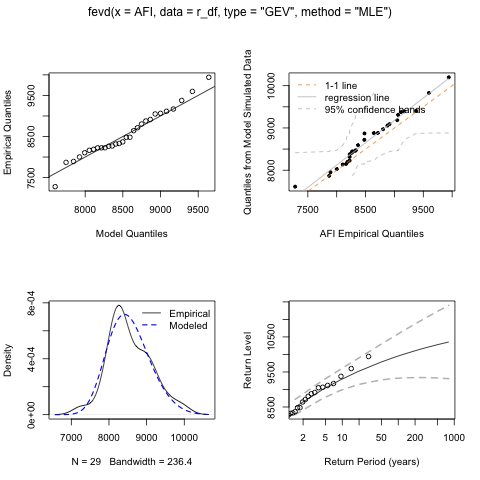

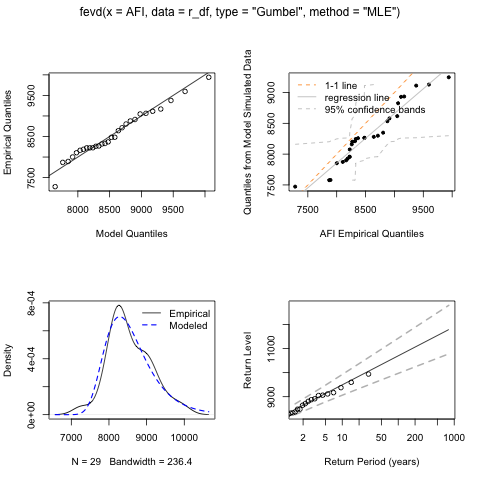

In [277]:
%R fitGEV <- fevd(AFI, data = r_df,type='GEV',method='MLE')
%R fitGumb <- fevd(AFI, data = r_df,type='Gumbel',method='MLE') # Gumbel shape=0
%R -o fitGEV,fitGumb
%R plot(fitGEV)
%R plot(fitGumb)

In [278]:
%R return_periods <- c(1.1,1.6,2,3,4,5,6,7,8,9,10,15, 20,25, 50,75, 100, 200,500,750,1000)
%R rlGEV<-return.level(fitGEV, return.period = return_periods, make.plot=TRUE)
%R rlGumb<-return.level(fitGumb, return.period = return_periods, make.plot=TRUE)
%R -o rlGEV,rlGumb


In [279]:
print(pgev)

(np.float64(-2.5729520869661555), np.float64(5.108058295013452), np.float64(12.261208252785233))


<>:57: SyntaxWarning: invalid escape sequence '\d'
<>:57: SyntaxWarning: invalid escape sequence '\d'
<>:57: SyntaxWarning: invalid escape sequence '\d'
<>:57: SyntaxWarning: invalid escape sequence '\d'
/var/folders/2z/v4x6xdj96rg1k3xrmwt26xtc0000gp/T/ipykernel_36969/714244814.py:57: SyntaxWarning: invalid escape sequence '\d'
  ax.set_title(f'{ilon}$\degree$E;{ilat}$\degree$N')
/var/folders/2z/v4x6xdj96rg1k3xrmwt26xtc0000gp/T/ipykernel_36969/714244814.py:57: SyntaxWarning: invalid escape sequence '\d'
  ax.set_title(f'{ilon}$\degree$E;{ilat}$\degree$N')


Text(0.5, 1.0, '205$\\degree$E;68.75$\\degree$N')

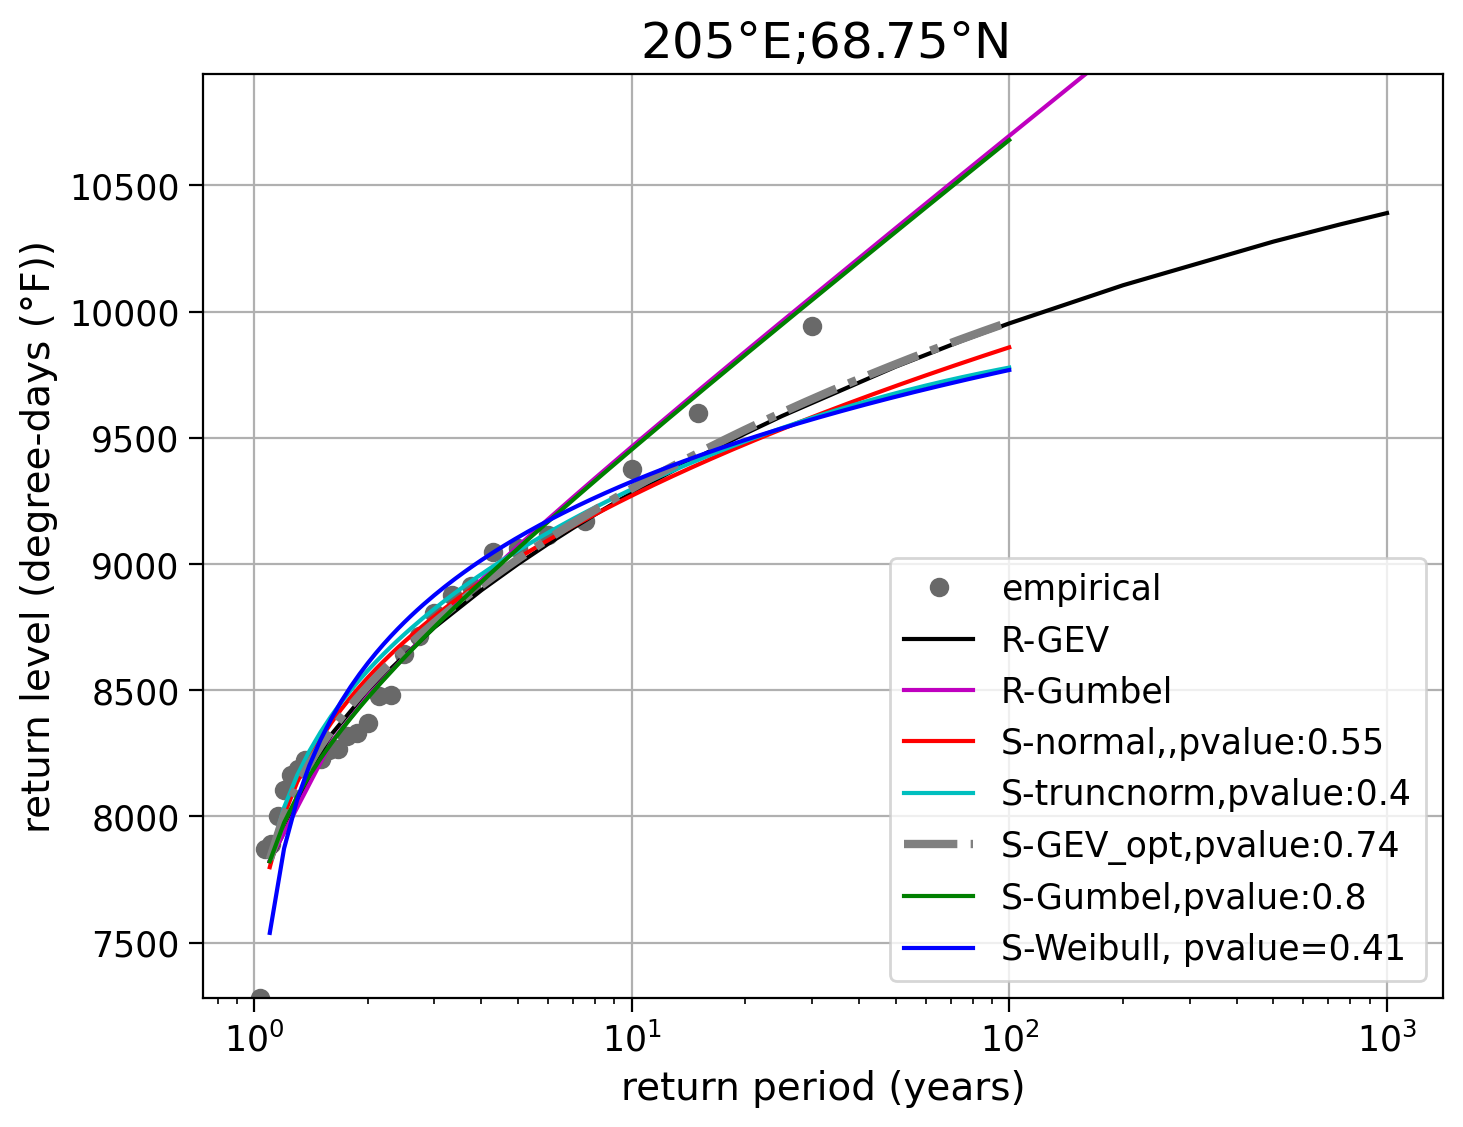

In [280]:

fig, ax = plt.subplots(nrows=1,ncols=1)
# plot empirical 
_ = empirical_return_level(nonzero_afis).plot(ax=ax, marker="o", color='dimgray',linestyle="None",label="empirical")

# plot R-distribution 
ax.plot(c,rlGEV,c='k',label='R-GEV')
ax.plot(c,rlGumb,c='m',label='R-Gumbel')


# calculate and plot the normal return levels
pv_n=np.round(stats.kstest(nonzero_afis,stats.norm.cdf, \
     args=(nonzero_afis.mean(),nonzero_afis.std()),N=ksN)[1],2)
ax.plot(years,stats.norm.ppf(1 - 1 / years, loc=nonzero_afis.mean(), scale=nonzero_afis.std())\
     ,c='r',label=f"S-normal,,pvalue:{pv_n}")

# calculate and plot the truncated gaussian return levels
loc_guess=nonzero_afis.mean()
scale_guess=nonzero_afis.std()
a_guess = (nonzero_afis.min() - loc_guess) / scale_guess
b_guess = (nonzero_afis.max() - loc_guess) / scale_guess

ptn = stats.truncnorm.fit(nonzero_afis,a_guess,b_guess,\
    scale= scale_guess, loc = loc_guess,  method='mle')
pv_tn=np.round(stats.kstest(nonzero_afis,stats.truncnorm.cdf, \
     args=ptn,N=ksN)[1],2)
ax.plot(years,stats.truncnorm.ppf(1 - 1 / years,*ptn),c='c',label=f"S-truncnorm,pvalue:{pv_tn}")

# calculate and plot the GEV distribution, optimized
pgev = gev.fit(nonzero_afis, method="MLE", optimizer=custom_optimizer)
pv_g= np.round(stats.kstest(nonzero_afis, 'genextreme', args=pgev, N=ksN)[1],2)
ax.plot(years, gev.ppf(1 - 1 / years, *pgev),c='grey',lw=3,ls='-.',label=f"S-GEV_opt,pvalue:{pv_g}")

# calculate and plot the Gumbel distribution
pgum = gev.fit(nonzero_afis,fc=0,method="MLE")
pv_gu= np.round(stats.kstest(nonzero_afis, 'genextreme', args=pgum, N=ksN)[1],2)
ax.plot(years, gev.ppf(1 - 1 / years,*pgum),c='g',label=f"S-Gumbel,pvalue:{pv_gu}")

# Weibul distribution
params = stats.weibull_min.fit(nonzero_afis, floc=0,optimizer=optimizer1) # floc=0 fixes the location parameter at 0
c_est, loc_est, scale_est = params
pv_w = stats.kstest(nonzero_afis, stats.weibull_min.name, params,N=ksN)[1]
ax.plot(years, stats.weibull_min(c_est, loc_est, scale_est).ppf(1 - 1 / years),c='b',label=f"S-Weibull, pvalue={pv_w:0.2f}")


#ax.set_xlim(0,100)
# set x axis to log scale
ax.set_xscale("log")

ax.set_ylabel(f'return level ({units})',fontsize=14)
ax.set_xlabel('return period (years)',fontsize=14)

ax.grid()
# set y axis lim
ax.set_ylim(nonzero_afis.min(),nonzero_afis.max()+1000.)
# show legend
ax.legend()
ax.set_title(f'{ilon}$\degree$E;{ilat}$\degree$N')

/var/folders/2z/v4x6xdj96rg1k3xrmwt26xtc0000gp/T/ipykernel_36969/527189141.py:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(),fontsize=14)
/var/folders/2z/v4x6xdj96rg1k3xrmwt26xtc0000gp/T/ipykernel_36969/527189141.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(),fontsize=14)


[Text(0, 0.0, '0.00000'),
 Text(0, 0.00025, '0.00025'),
 Text(0, 0.0005, '0.00050'),
 Text(0, 0.00075, '0.00075'),
 Text(0, 0.001, '0.00100'),
 Text(0, 0.00125, '0.00125'),
 Text(0, 0.0015, '0.00150'),
 Text(0, 0.00175, '0.00175'),
 Text(0, 0.002, '0.00200')]

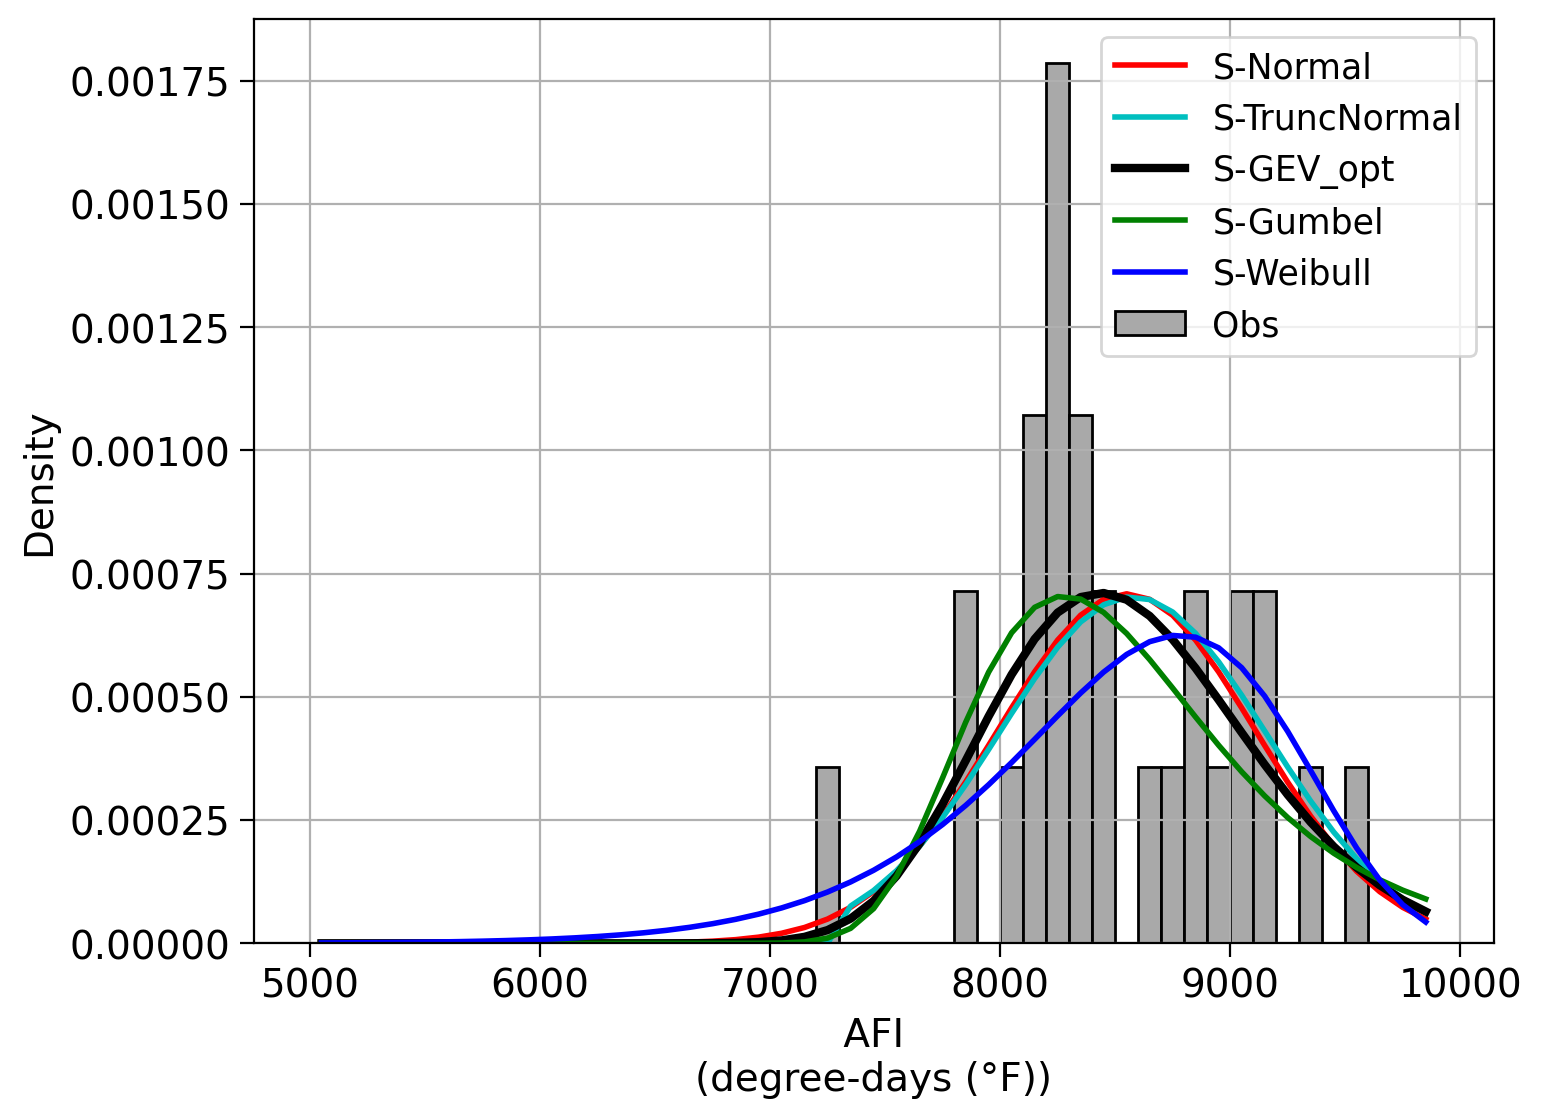

In [281]:
####
##### PDF Plot
#####

bins = np.arange(5000,10000,100)
x100 = (bins[1:]+bins[:-1])*0.5
# create vector of years
years = np.arange(1.1, 100, 0.1)

fig, ax= plt.subplots(nrows=1,ncols=1,figsize=(8,6))
dh=histogram(afi.where(afi>0), bins=bins,density=True, block_size=None)
ax.bar((bins[1:]+bins[:-1])*0.5,dh.data,edgecolor='k',color='darkgrey',\
          width=np.diff(bins), label='Obs')

# normal distribution
ax.plot(x100,stats.norm.pdf(x100, loc=nonzero_afis.mean(), scale=nonzero_afis.std()),
    c="r",lw=2,label="S-Normal")
# normal distribution
ax.plot(x100,stats.truncnorm.pdf(x100, *ptn),
    c="c",lw=2,label="S-TruncNormal")    
# GEV distribution
ax.plot(x100, gev.pdf(x100, *pgev), c="k", lw=3, label="S-GEV_opt")
# Gumbl distribution
ax.plot(x100, gev.pdf(x100, *pgum), c="g", lw=2, label="S-Gumbel")

# Weibul distribution
ax.plot(x100, stats.weibull_min(c_est, loc_est, scale_est).pdf(x100), c="b", lw=2, label="S-Weibull")

# calculate and plot the Gumbl distribution
shape, loc, scale = gev.fit(nonzero_afis,0)
ax.legend()
ax.grid()
ax.set_xlabel(f" AFI \n({units})",fontsize=14)
ax.set_ylabel("Density",fontsize=14)
ax.set_xticklabels(ax.get_xticklabels(),fontsize=14)
ax.set_yticklabels(ax.get_yticklabels(),fontsize=14)

# Pt 6

In [282]:
ij=5
ilon=ptlon[ij]
ilat=ptlat[ij]
afi=ds['AFI'].sel(lon=ilon,lat=ilat).load()

# Extract AFI values
afi_values = afi.values
# Remove zeros if any (as in Bilotta et al.)
nonzero_afis = afi_values[afi_values > 0]

df = afi.where(afi>0).to_dataframe()
df=df.drop(columns=['lat','lon'])
df['year'] = df.index

# Convert pandas DataFrame to R data.frame
r_df = ro.conversion.py2rpy(df)

# You can now work with 'r_df' in R
print(ro.r['summary'](r_df))
globalenv['r_df'] = r_df

['Min.   :1042  ' '1st Qu.:2359  ' 'Median :2702  ' 'Mean   :2636  '
 '3rd Qu.:3078  ' 'Max.   :3648  ' 'Min.   :1980  ' '1st Qu.:1987  '
 'Median :1994  ' 'Mean   :1994  ' '3rd Qu.:2001  ' 'Max.   :2008  ']


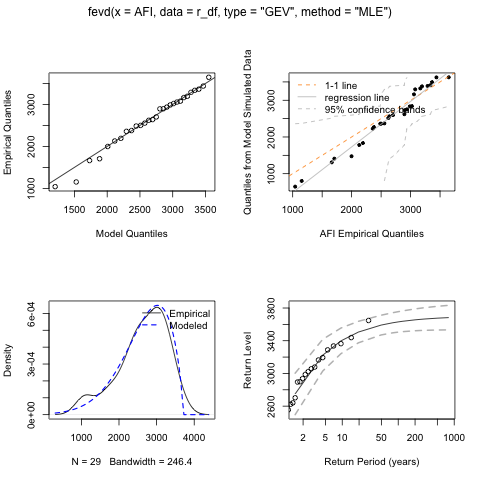

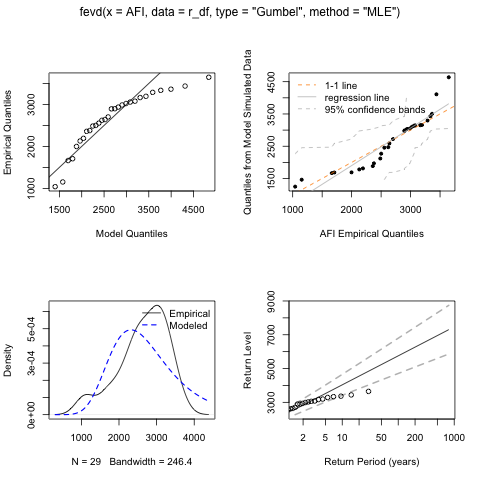

In [283]:
%R fitGEV <- fevd(AFI, data = r_df,type='GEV',method='MLE')
%R fitGumb <- fevd(AFI, data = r_df,type='Gumbel',method='MLE') # Gumbel shape=0
%R -o fitGEV,fitGumb
%R plot(fitGEV)
%R plot(fitGumb)

In [284]:
%R return_periods <- c(1.1,1.6,2,3,4,5,6,7,8,9,10,15, 20,25, 50,75, 100, 200,500,750,1000)
%R rlGEV<-return.level(fitGEV, return.period = return_periods, make.plot=TRUE)
%R rlGumb<-return.level(fitGumb, return.period = return_periods, make.plot=TRUE)
%R -o rlGEV,rlGumb


<>:57: SyntaxWarning: invalid escape sequence '\d'
<>:57: SyntaxWarning: invalid escape sequence '\d'
<>:57: SyntaxWarning: invalid escape sequence '\d'
<>:57: SyntaxWarning: invalid escape sequence '\d'
/var/folders/2z/v4x6xdj96rg1k3xrmwt26xtc0000gp/T/ipykernel_36969/3603268883.py:57: SyntaxWarning: invalid escape sequence '\d'
  ax.set_title(f'{ilon}$\degree$E;{ilat}$\degree$N')
/var/folders/2z/v4x6xdj96rg1k3xrmwt26xtc0000gp/T/ipykernel_36969/3603268883.py:57: SyntaxWarning: invalid escape sequence '\d'
  ax.set_title(f'{ilon}$\degree$E;{ilat}$\degree$N')


Text(0.5, 1.0, '204$\\degree$E;60$\\degree$N')

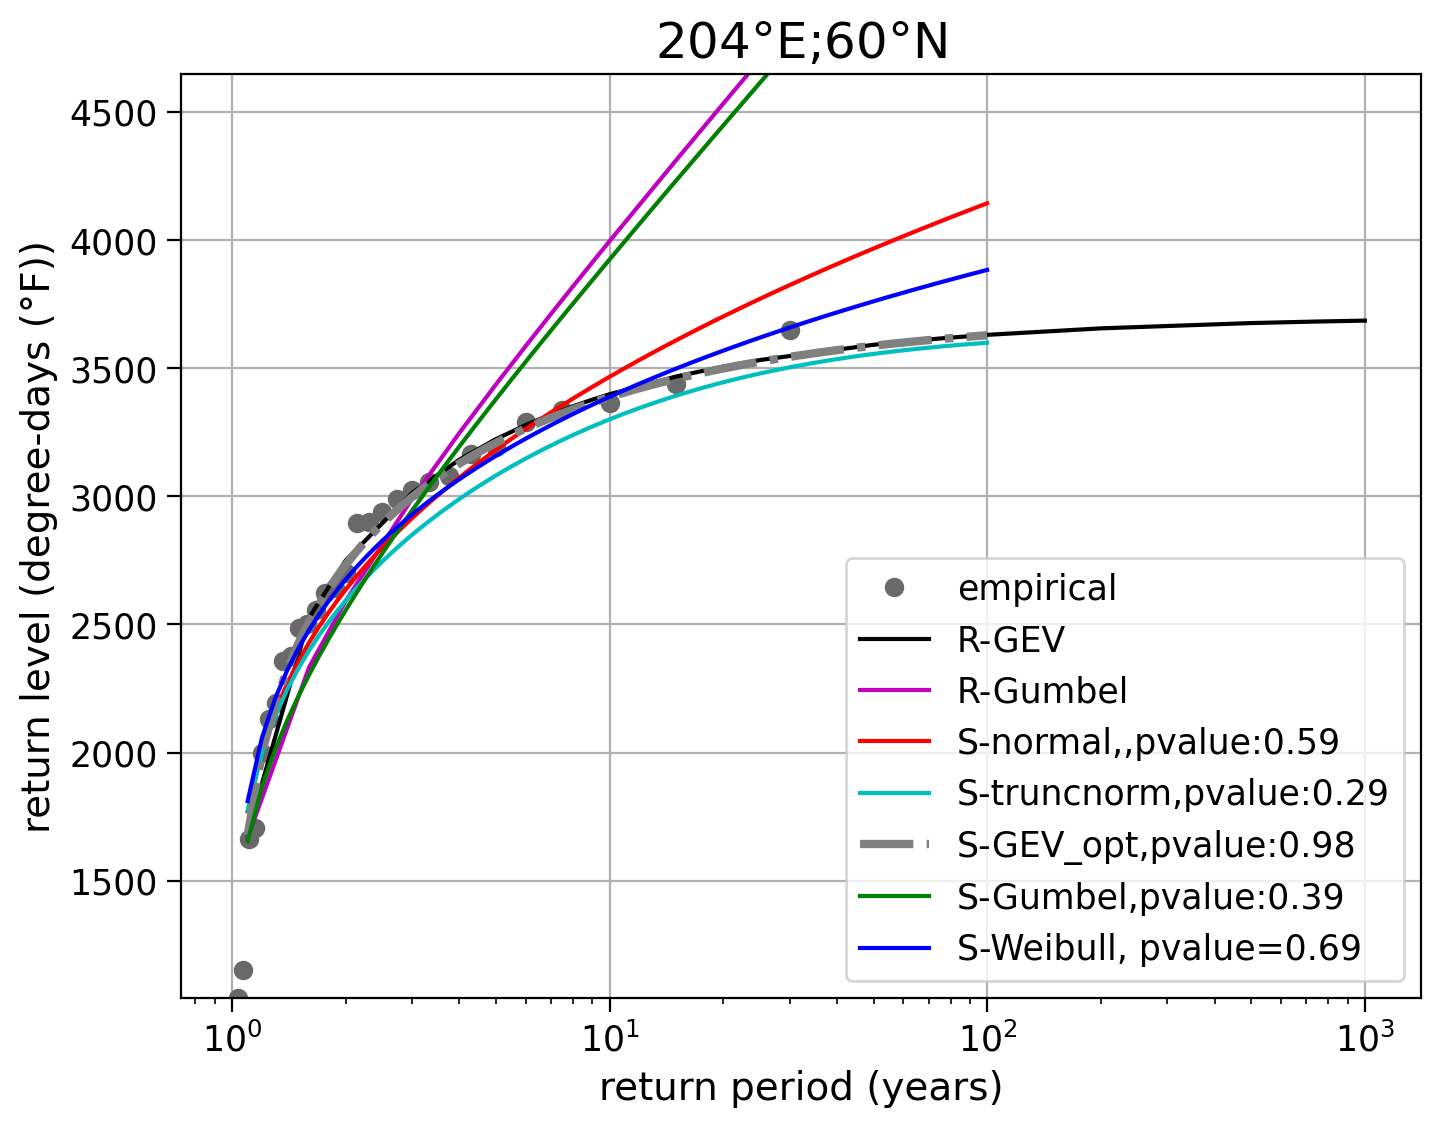

In [285]:

fig, ax = plt.subplots(nrows=1,ncols=1)
# plot empirical 
_ = empirical_return_level(nonzero_afis).plot(ax=ax, marker="o", color='dimgray',linestyle="None",label="empirical")

# plot R-distribution 
ax.plot(c,rlGEV,c='k',label='R-GEV')
ax.plot(c,rlGumb,c='m',label='R-Gumbel')


# calculate and plot the normal return levels
pv_n=np.round(stats.kstest(nonzero_afis,stats.norm.cdf, \
     args=(nonzero_afis.mean(),nonzero_afis.std()),N=ksN)[1],2)
ax.plot(years,stats.norm.ppf(1 - 1 / years, loc=nonzero_afis.mean(), scale=nonzero_afis.std())\
     ,c='r',label=f"S-normal,,pvalue:{pv_n}")

# calculate and plot the truncated gaussian return levels
loc_guess=nonzero_afis.mean()
scale_guess=nonzero_afis.std()
a_guess = (nonzero_afis.min() - loc_guess) / scale_guess
b_guess = (nonzero_afis.max() - loc_guess) / scale_guess

ptn = stats.truncnorm.fit(nonzero_afis,a_guess,b_guess,\
    scale= scale_guess, loc = loc_guess,  method='mle')
pv_tn=np.round(stats.kstest(nonzero_afis,stats.truncnorm.cdf, \
     args=ptn,N=ksN)[1],2)
ax.plot(years,stats.truncnorm.ppf(1 - 1 / years,*ptn),c='c',label=f"S-truncnorm,pvalue:{pv_tn}")

# calculate and plot the GEV distribution, optimized
pgev = gev.fit(nonzero_afis, method="MLE", optimizer=custom_optimizer)
pv_g= np.round(stats.kstest(nonzero_afis, 'genextreme', args=pgev, N=ksN)[1],2)
ax.plot(years, gev.ppf(1 - 1 / years, *pgev),c='grey',lw=3,ls='-.',label=f"S-GEV_opt,pvalue:{pv_g}")

# calculate and plot the Gumbel distribution
pgum = gev.fit(nonzero_afis,fc=0,method="MLE")#,optimizer=optimizer1)
pv_gu= np.round(stats.kstest(nonzero_afis, 'genextreme', args=pgum, N=ksN)[1],2)
ax.plot(years, gev.ppf(1 - 1 / years,*pgum),c='g',label=f"S-Gumbel,pvalue:{pv_gu}")

# Weibul distribution
params = stats.weibull_min.fit(nonzero_afis, floc=0,optimizer=optimizer1) # floc=0 fixes the location parameter at 0
c_est, loc_est, scale_est = params
pv_w = stats.kstest(nonzero_afis, stats.weibull_min.name, params,N=ksN)[1]
ax.plot(years, stats.weibull_min(c_est, loc_est, scale_est).ppf(1 - 1 / years),c='b',label=f"S-Weibull, pvalue={pv_w:0.2f}")


#ax.set_xlim(0,100)
# set x axis to log scale
ax.set_xscale("log")

ax.set_ylabel(f'return level ({units})',fontsize=14)
ax.set_xlabel('return period (years)',fontsize=14)

ax.grid()
# set y axis lim
ax.set_ylim(nonzero_afis.min(),nonzero_afis.max()+1000.)
# show legend
ax.legend()
ax.set_title(f'{ilon}$\degree$E;{ilat}$\degree$N')

/var/folders/2z/v4x6xdj96rg1k3xrmwt26xtc0000gp/T/ipykernel_36969/27051560.py:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(),fontsize=14)
/var/folders/2z/v4x6xdj96rg1k3xrmwt26xtc0000gp/T/ipykernel_36969/27051560.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(),fontsize=14)


[Text(0, 0.0, '0.0000'),
 Text(0, 0.0002, '0.0002'),
 Text(0, 0.0004, '0.0004'),
 Text(0, 0.0006000000000000001, '0.0006'),
 Text(0, 0.0008, '0.0008'),
 Text(0, 0.001, '0.0010'),
 Text(0, 0.0012000000000000001, '0.0012')]

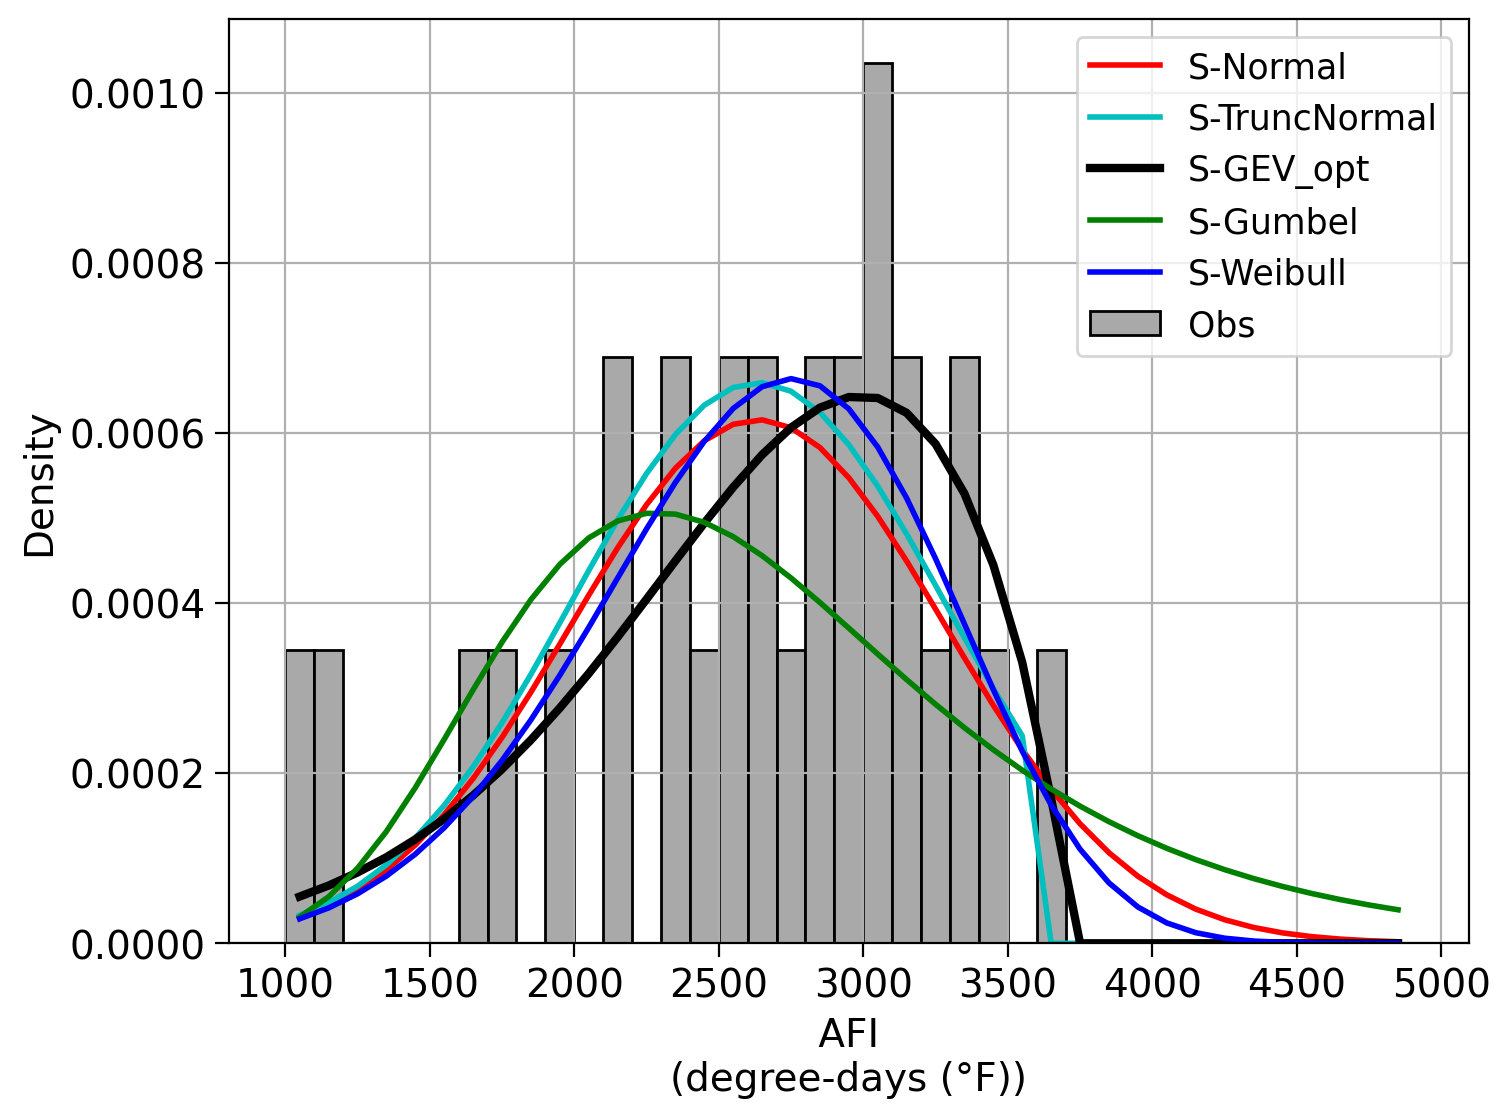

In [286]:
####
##### PDF Plot
#####

bins = np.arange(1000,5000,100)
x100 = (bins[1:]+bins[:-1])*0.5
# create vector of years
years = np.arange(1.1, 100, 0.1)

fig, ax= plt.subplots(nrows=1,ncols=1,figsize=(8,6))
dh=histogram(afi.where(afi>0), bins=bins,density=True, block_size=None)
ax.bar((bins[1:]+bins[:-1])*0.5,dh.data,edgecolor='k',color='darkgrey',\
          width=np.diff(bins), label='Obs')

# normal distribution
ax.plot(x100,stats.norm.pdf(x100, loc=nonzero_afis.mean(), scale=nonzero_afis.std()),
    c="r",lw=2,label="S-Normal")
# normal distribution
ax.plot(x100,stats.truncnorm.pdf(x100, *ptn),
    c="c",lw=2,label="S-TruncNormal")    
# GEV distribution
ax.plot(x100, gev.pdf(x100, *pgev), c="k", lw=3, label="S-GEV_opt")
# Gumbl distribution
ax.plot(x100, gev.pdf(x100, *pgum), c="g", lw=2, label="S-Gumbel")

# Weibul distribution
ax.plot(x100, stats.weibull_min(c_est, loc_est, scale_est).pdf(x100), c="b", lw=2, label="S-Weibull")

# calculate and plot the Gumbl distribution
shape, loc, scale = gev.fit(nonzero_afis,0)
ax.legend()
ax.grid()
ax.set_xlabel(f" AFI \n({units})",fontsize=14)
ax.set_ylabel("Density",fontsize=14)
ax.set_xticklabels(ax.get_xticklabels(),fontsize=14)
ax.set_yticklabels(ax.get_yticklabels(),fontsize=14)